In [1]:
!pip install dython

In [37]:
import copy
import os
import warnings
from pathlib import Path
from typing import Dict, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dython.nominal import associations, numerical_encoding
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNet, Lasso, LogisticRegression, Ridge
from sklearn.metrics import f1_score, jaccard_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

from metrics import *
from notebook import EvaluationResult, isnotebook, visualize_notebook
from utils import dict_to_df
from viz import *


class TableEvaluator:
    """
    Class for evaluating synthetic data. It is given the real and fake data and allows the user to easily evaluate data with the `evaluate` method.
    Additional evaluations can be done with the different methods of evaluate and the visual evaluation method.
    """

    def __init__(self, real: pd.DataFrame, fake: pd.DataFrame, cat_cols=None, unique_thresh=0, metric='pearsonr',
                 verbose=False, n_samples=None, name: str = None, seed=1337):
        """
        :param real: Real dataset (pd.DataFrame)
        :param fake: Synthetic dataset (pd.DataFrame)
        :param unique_thresh: Threshold for automatic evaluation if column is numeric
        :param cat_cols: The columns that are to be evaluated as discrete. If passed, unique_thresh is ignored.
        :param metric: the metric to use for evaluation linear relations. Pearson's r by default, but supports all models in scipy.stats
        :param verbose: Whether to print verbose output
        :param n_samples: Number of samples to evaluate. If none, it will take the minimal length of both datasets and cut the larger one off to make sure they
            are the same length.
        :param name: Name of the TableEvaluator. Used in some plotting functions like `viz.plot_correlation_comparison` to indicate your model.
        """
        self.name = name
        self.unique_thresh = unique_thresh
        self.real = real.copy()
        self.fake = fake.copy()
        self.comparison_metric = getattr(stats, metric)
        self.verbose = verbose
        self.random_seed = seed

        # Make sure columns and their order are the same.
        if len(real.columns) == len(fake.columns):
            fake = fake[real.columns.tolist()]
        assert real.columns.tolist() == fake.columns.tolist(), 'Columns in real and fake dataframe are not the same'

        if cat_cols is None:
            real = real.infer_objects()
            fake = fake.infer_objects()
            self.numerical_columns = [column for column in real.select_dtypes(include='number').columns if
                                      len(real[column].unique()) > unique_thresh]
            self.categorical_columns = [column for column in real.columns if column not in self.numerical_columns]
        else:
            self.categorical_columns = cat_cols
            self.numerical_columns = [column for column in real.columns if column not in cat_cols]

        # Make sure the number of samples is equal in both datasets.
        if n_samples is None:
            self.n_samples = min(len(self.real), len(self.fake))
        elif len(fake) >= n_samples and len(real) >= n_samples:
            self.n_samples = n_samples
        else:
            raise Exception(f'Make sure n_samples < len(fake/real). len(real): {len(real)}, len(fake): {len(fake)}')

        self.real = self.real.sample(self.n_samples)
        self.fake = self.fake.sample(self.n_samples)
        assert len(self.real) == len(self.fake), f'len(real) != len(fake)'

        self.real.loc[:, self.categorical_columns] = self.real.loc[:, self.categorical_columns].fillna('[NAN]').astype(
            str)
        self.fake.loc[:, self.categorical_columns] = self.fake.loc[:, self.categorical_columns].fillna('[NAN]').astype(
            str)

        self.real.loc[:, self.numerical_columns] = self.real.loc[:, self.numerical_columns].fillna(
            self.real[self.numerical_columns].mean())
        self.fake.loc[:, self.numerical_columns] = self.fake.loc[:, self.numerical_columns].fillna(
            self.fake[self.numerical_columns].mean())

    def plot_mean_std(self, fname=None):
        """
        Class wrapper function for plotting the mean and std using `viz.plot_mean_std`.
        :param fname: If not none, saves the plot with this file name.
        """
        plot_mean_std(self.real, self.fake, fname=fname)

    def plot_cumsums(self, nr_cols=4, fname=None):
        """
        Plot the cumulative sums for all columns in the real and fake dataset. Height of each row scales with the length of the labels. Each plot contains the
        values of a real columns and the corresponding fake column.
        :param fname: If not none, saves the plot with this file name.
        """
        nr_charts = len(self.real.columns)
        nr_rows = max(1, nr_charts // nr_cols)
        nr_rows = nr_rows + 1 if nr_charts % nr_cols != 0 else nr_rows

        max_len = 0
        # Increase the length of plots if the labels are long
        if not self.real.select_dtypes(include=['object']).empty:
            lengths = []
            for d in self.real.select_dtypes(include=['object']):
                lengths.append(max([len(x.strip()) for x in self.real[d].unique().tolist()]))
            max_len = max(lengths)

        row_height = 6 + (max_len // 30)
        fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(16, row_height * nr_rows))
        fig.suptitle('Cumulative Sums per feature', fontsize=16)
        axes = ax.flatten()
        for i, col in enumerate(self.real.columns):
            try:
                r = self.real[col]
                f = self.fake.iloc[:, self.real.columns.tolist().index(col)]
                cdf(r, f, col, 'Cumsum', ax=axes[i])
            except Exception as e:
                print(f'Error while plotting column {col}')
                raise e

        plt.tight_layout(rect=[0, 0.02, 1, 0.98])

        if fname is not None:
            plt.savefig(fname)

        plt.show()

    def correlation_distance(self, how: str = 'euclidean') -> float:
        """
        Calculate distance between correlation matrices with certain metric.

        :param how: metric to measure distance. Choose from [``euclidean``, ``mae``, ``rmse``].
        :return: distance between the association matrices in the chosen evaluation metric. Default: Euclidean
        """
        from scipy.spatial.distance import cosine
        if how == 'euclidean':
            distance_func = euclidean_distance
        elif how == 'mae':
            distance_func = mean_absolute_error
        elif how == 'rmse':
            distance_func = rmse
        elif how == 'cosine':
            def custom_cosine(a, b):
                return cosine(a.reshape(-1), b.reshape(-1))

            distance_func = custom_cosine
        else:
            raise ValueError(f'`how` parameter must be in [euclidean, mae, rmse]')

        real_corr = associations(self.real, nominal_columns=self.categorical_columns, nom_nom_assoc='theil', compute_only=True)['corr'] # type: ignore
        fake_corr = associations(self.fake, nominal_columns=self.categorical_columns, nom_nom_assoc='theil', compute_only=True)['corr'] # type: ignore
        return distance_func(
            real_corr.values,
            fake_corr.values
        ) # type: ignore


    def get_copies(self, return_len: bool = False) -> Union[pd.DataFrame, int]:
        """
        Check whether any real values occur in the fake data.

        :param return_len: whether to return the length of the copied rows or not.
        :return: Dataframe containing the duplicates if return_len=False, else integer indicating the number of copied rows.
        """
        real_hashes = self.real.apply(lambda x: hash(tuple(x)), axis=1)
        fake_hashes = self.fake.apply(lambda x: hash(tuple(x)), axis=1)

        dup_idxs = fake_hashes.isin(real_hashes.values)
        dup_idxs = dup_idxs[dup_idxs == True].sort_index().index.tolist()

        if self.verbose:
            print(f'Nr copied columns: {len(dup_idxs)}')
        copies = self.fake.loc[dup_idxs, :]

        if return_len:
            return len(copies)
        else:
            return copies

    def get_duplicates(self, return_values: bool = False) -> Tuple[Union[pd.DataFrame, int], Union[pd.DataFrame, int]]:
        """
        Return duplicates within each dataset.

        :param return_values: whether to return the duplicate values in the datasets. If false, the lengths are returned.
        :return: dataframe with duplicates or the length of those dataframes if return_values=False.
        """
        real_duplicates = self.real[self.real.duplicated(keep=False)]
        fake_duplicates = self.fake[self.fake.duplicated(keep=False)]
        if return_values:
            return real_duplicates, fake_duplicates
        else:
            return len(real_duplicates), len(fake_duplicates)

    def pca_correlation(self, lingress=False):
        """
        Calculate the relation between PCA explained variance values. Due to some very large numbers, in recent implementation the MAPE(log) is used instead of
        regressions like Pearson's r.

        :param lingress: whether to use a linear regression, in this case Pearson's.
        :return: the correlation coefficient if lingress=True, otherwise 1 - MAPE(log(real), log(fake))
        """
        self.pca_r = PCA(n_components=5)
        self.pca_f = PCA(n_components=5)

        real, fake = self.convert_numerical()

        self.pca_r.fit(real)
        self.pca_f.fit(fake)
        if self.verbose:
            results = pd.DataFrame({'real': self.pca_r.explained_variance_, 'fake': self.pca_f.explained_variance_})
            print(f'\nTop 5 PCA components:')
            print(results.to_string())

        if lingress:
            corr, p, _ = self.comparison_metric(self.pca_r.explained_variance_, self.pca_f.explained_variance_)
            return corr
        else:
            pca_error = mean_absolute_percentage_error(self.pca_r.explained_variance_, self.pca_f.explained_variance_)
            return 1 - pca_error

    def fit_estimators(self):
        """
        Fit self.r_estimators and self.f_estimators to real and fake data, respectively.
        """

        if self.verbose:
            print(f'\nFitting real')
        for i, c in enumerate(self.r_estimators):
            if self.verbose:
                print(f'{i + 1}: {type(c).__name__}')
            c.fit(self.real_x_train, self.real_y_train)

        if self.verbose:
            print(f'\nFitting fake')
        for i, c in enumerate(self.f_estimators):
            if self.verbose:
                print(f'{i + 1}: {type(c).__name__}')
            c.fit(self.fake_x_train, self.fake_y_train)

    def score_estimators(self):
        """
        Get F1 scores of self.r_estimators and self.f_estimators on the fake and real data, respectively.

        :return: dataframe with the results for each estimator on each data test set.
        """
        if self.target_type == 'class':
            rows = []
            for r_classifier, f_classifier, estimator_name in zip(self.r_estimators, self.f_estimators,
                                                                  self.estimator_names):
                for dataset, target, dataset_name in zip([self.real_x_test, self.fake_x_test],
                                                         [self.real_y_test, self.fake_y_test], ['real', 'fake']):
                    predictions_classifier_real = r_classifier.predict(dataset)
                    predictions_classifier_fake = f_classifier.predict(dataset)
                    f1_r = f1_score(target, predictions_classifier_real, average='micro')
                    f1_f = f1_score(target, predictions_classifier_fake, average='micro')
                    jac_sim = jaccard_score(predictions_classifier_real, predictions_classifier_fake, average='micro')
                    row = {'index': f'{estimator_name}_{dataset_name}', 'f1_real': f1_r, 'f1_fake': f1_f,
                           'jaccard_similarity': jac_sim}
                    rows.append(row)
            results = pd.DataFrame(rows).set_index('index')

        elif self.target_type == 'regr':
            r2r = [rmse(self.real_y_test, clf.predict(self.real_x_test)) for clf in self.r_estimators]
            f2f = [rmse(self.fake_y_test, clf.predict(self.fake_x_test)) for clf in self.f_estimators]

            # Calculate test set accuracies on the other dataset
            r2f = [rmse(self.fake_y_test, clf.predict(self.fake_x_test)) for clf in self.r_estimators]
            f2r = [rmse(self.real_y_test, clf.predict(self.real_x_test)) for clf in self.f_estimators]
            index = [f'real_data_{classifier}' for classifier in self.estimator_names] + \
                    [f'fake_data_{classifier}' for classifier in self.estimator_names]
            results = pd.DataFrame({'real': r2r + f2r, 'fake': r2f + f2f}, index=index)
        else:
            raise Exception(f'self.target_type should be either \'class\' or \'regr\', but is {self.target_type}.')
        return results

    def visual_evaluation(self, save_dir=None, **kwargs):
        """
        Plot all visual evaluation metrics. Includes plotting the mean and standard deviation, cumulative sums, correlation differences and the PCA transform.
        :save_dir: directory path to save images
        :param kwargs: any kwargs for matplotlib.
        """
        if save_dir is None:
            self.plot_mean_std()
            self.plot_cumsums()
            self.plot_distributions()
            self.plot_correlation_difference(**kwargs)
            self.plot_pca()
        else:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)

            self.plot_mean_std(fname=save_dir/'mean_std.png')
            self.plot_cumsums(fname=save_dir/'cumsums.png')
            self.plot_distributions(fname=save_dir/'distributions.png')
            self.plot_correlation_difference(fname=save_dir/'correlation_difference.png', **kwargs)
            self.plot_pca(fname=save_dir/'pca.png')


    def basic_statistical_evaluation(self) -> float:
        """
        Calculate the correlation coefficient between the basic properties of self.real and self.fake using Spearman's Rho. Spearman's is used because these
        values can differ a lot in magnitude, and Spearman's is more resilient to outliers.

        :return: correlation coefficient
        """
        total_metrics = pd.DataFrame()
        for ds_name in ['real', 'fake']:
            ds = getattr(self, ds_name)
            metrics = {}
            # TODO: add discrete columns as factors
            num_ds = ds[self.numerical_columns]

            for idx, value in num_ds.mean().items():
                metrics[f'mean_{idx}'] = value
            for idx, value in num_ds.median().items():
                metrics[f'median_{idx}'] = value
            for idx, value in num_ds.std().items():
                metrics[f'std_{idx}'] = value
            for idx, value in num_ds.var().items():
                metrics[f'variance_{idx}'] = value
            total_metrics[ds_name] = metrics.values()

        total_metrics.index = metrics.keys()
        self.statistical_results = total_metrics
        if self.verbose:
            print('\nBasic statistical attributes:')
            print(total_metrics.to_string())
        corr, p = stats.spearmanr(total_metrics['real'], total_metrics['fake'])
        return corr

    def correlation_correlation(self) -> float:
        """
        Calculate the correlation coefficient between the association matrices of self.real and self.fake using self.comparison_metric

        :return: The correlation coefficient
        """
        total_metrics = pd.DataFrame()
        for ds_name in ['real', 'fake']:
            ds = getattr(self, ds_name)
            corr_df: pd.DataFrame = associations(ds, nominal_columns=self.categorical_columns, nom_nom_assoc='theil', compute_only=True)['corr']
            values = corr_df.values
            # print(values, type(values))
            values = values[~np.eye(values.shape[0], dtype=bool)].reshape(values.shape[0], -1)
            total_metrics[ds_name] = values.flatten()

        self.correlation_correlations = total_metrics
        corr, p = self.comparison_metric(total_metrics['real'], total_metrics['fake'])
        if self.verbose:
            print('\nColumn correlation between datasets:')
            print(total_metrics.to_string())
        return corr

    def convert_numerical(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Special function to convert dataset to a numerical representations while making sure they have identical columns. This is sometimes a problem with
        categorical columns with many values or very unbalanced values

        :return: Real and fake dataframe factorized using the pandas function
        """
        real = self.real
        fake = self.fake
        for c in self.categorical_columns:
            if real[c].dtype == 'object':
                real[c] = pd.factorize(real[c], sort=True)[0]
                fake[c] = pd.factorize(fake[c], sort=True)[0]

        return real, fake

    def convert_numerical_one_hot(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Special function to convert dataset to a numerical representations while making sure they have identical columns. This is sometimes a problem with
        categorical columns with many values or very unbalanced values

        :return: Real and fake dataframe with categorical columns one-hot encoded and binary columns factorized.
        """
        real: pd.DataFrame = numerical_encoding(self.real, nominal_columns=self.categorical_columns)
        real = real.sort_index(axis=1)
        fake: pd.DataFrame = numerical_encoding(self.fake, nominal_columns=self.categorical_columns)
        for col in real.columns:
            if col not in fake:
                fake[col] = 0
        fake = fake.sort_index(axis=1)

        # Cast True/False columns to 0/1.
        bool_cols = real.select_dtypes('bool').columns
        real[bool_cols] = real[bool_cols].astype(float)
        fake[bool_cols] = fake[bool_cols].astype(float)

        return real, fake

    def estimator_evaluation(self, target_col: str, target_type: str = 'class', kfold: bool = False) -> float:
        """
        Method to do full estimator evaluation, including training. And estimator is either a regressor or a classifier, depending on the task. Two sets are
        created of each of the estimators `S_r` and `S_f`, for the real and fake data respectively. `S_f` is trained on ``self.real`` and `S_r` on
        ``self.fake``. Then, both are evaluated on their own and the others test set. If target_type is ``regr`` we do a regression on the RMSE scores with
        Pearson's. If target_type is ``class``, we calculate F1 scores and do return ``1 - MAPE(F1_r, F1_f)``.

        :param target_col: which column should be considered the target both both the regression and classification task.
        :param target_type: what kind of task this is. Can be either ``class`` or ``regr``.
        :param kfold: if set to True, will perform 5-fold CV, otherwise will just train on 80% and test on 20% of the data once.
        :return: Correlation value or 1 - MAPE
        """
        self.target_col = target_col
        self.target_type = target_type

        # Convert both datasets to numerical representations and split x and  y
        real, fake = self.convert_numerical()

        real_x = real.drop([target_col], axis=1)
        fake_x = fake.drop([target_col], axis=1)

        assert real_x.columns.tolist() == fake_x.columns.tolist(), f'real and fake columns are different: \n{real_x.columns}\n{fake_x.columns}'

        real_y = real[target_col]
        fake_y = fake[target_col]

        # For reproducibilty:
        np.random.seed(self.random_seed)

        if target_type == 'regr':
            self.estimators = [
                RandomForestRegressor(n_estimators=20, max_depth=5, random_state=42),
                Lasso(random_state=42),
                Ridge(alpha=1.0, random_state=42),
                ElasticNet(random_state=42),
            ]
        elif target_type == 'class':
            self.estimators = [
                LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=500, random_state=42),
                RandomForestClassifier(n_estimators=10, random_state=42),
                DecisionTreeClassifier(random_state=42),
                MLPClassifier([50, 50], solver='adam', activation='relu', learning_rate='adaptive', random_state=42),
            ]
        else:
            raise ValueError(f'target_type must be \'regr\' or \'class\'')

        self.estimator_names = [type(clf).__name__ for clf in self.estimators]

        # K Fold
        kf = KFold(n_splits=5)
        res = []
        for train_index, test_index in kf.split(real_y):
            self.real_x_train = real_x.iloc[train_index]
            self.real_x_test = real_x.iloc[test_index]
            self.real_y_train = real_y.iloc[train_index]
            self.real_y_test = real_y.iloc[test_index]
            self.fake_x_train = fake_x.iloc[train_index]
            self.fake_x_test = fake_x.iloc[test_index]
            self.fake_y_train = fake_y.iloc[train_index]
            self.fake_y_test = fake_y.iloc[test_index]

            self.r_estimators = copy.deepcopy(self.estimators)
            self.f_estimators = copy.deepcopy(self.estimators)

            for estimator in self.estimators:
                assert hasattr(estimator, 'fit')
                assert hasattr(estimator, 'score')

            self.fit_estimators()
            res.append(self.score_estimators())

            # Break the loop if we don't want the kfold
            if not kfold:
                break

        self.estimators_scores = pd.concat(res).groupby(level=0).mean()
        if self.verbose:
            print('\nClassifier F1-scores and their Jaccard similarities:') if self.target_type == 'class' \
                else print('\nRegressor MSE-scores and their Jaccard similarities:')
            print(self.estimators_scores.to_string())

        if self.target_type == 'regr':
            corr, p = self.comparison_metric(self.estimators_scores['real'], self.estimators_scores['fake'])
            return corr
        elif self.target_type == 'class':
            mean = mean_absolute_percentage_error(self.estimators_scores['f1_real'], self.estimators_scores['f1_fake'])
            return 1 - mean
        else:
            raise ValueError('`self.target_type` should be `regr` or `class`.')

    def row_distance(self, n_samples: int = None) -> Tuple[np.number, np.number]:
        """
        Calculate mean and standard deviation distances between `self.fake` and `self.real`.

        :param n_samples: Number of samples to take for evaluation. Compute time increases exponentially.
        :return: `(mean, std)` of these distances.
        """
        if n_samples is None:
            n_samples = len(self.real)

        real, fake = self.convert_numerical_one_hot()

        columns = sorted(real.columns.tolist())
        real = real[columns]

        for col in columns:
            if col not in fake.columns.tolist():
                fake[col] = 0
        fake = fake[columns]

        for column in real.columns.tolist():
            if len(real[column].unique()) > 2:
                real[column] = (real[column] - real[column].mean()) / real[column].std()
                fake[column] = (fake[column] - fake[column].mean()) / fake[column].std()
        assert real.columns.tolist() == fake.columns.tolist()

        distances = cdist(real[:n_samples], fake[:n_samples])
        min_distances = np.min(distances, axis=1)
        min_mean = np.mean(min_distances)
        min_std = np.std(min_distances)
        return min_mean, min_std

    def column_correlations(self):
        """
        Wrapper function around `metrics.column_correlation`.

        :return: Column correlations between ``self.real`` and ``self.fake``.
        """

        real, fake = self.convert_numerical()

        return column_correlations(real, fake, self.categorical_columns)

    def evaluate(self, target_col: str, target_type: str = 'class', metric: str = None, verbose: bool = None,
                 n_samples_distance: int = 20000, kfold: bool = False, notebook: bool = False, return_outputs: bool = False) -> Dict:
        """
        Determine correlation between attributes from the real and fake dataset using a given metric.
        All metrics from scipy.stats are available.

        :param target_col: column to use for predictions with estimators
        :param target_type: what kind of task to perform on the target_col. Can be either ``class`` for classification or ``regr`` for regression.
        :param metric: overwrites self.metric. Scoring metric for the attributes.
            By default Pearson's r is used. Alternatives include Spearman rho (scipy.stats.spearmanr) or Kendall Tau (scipy.stats.kendalltau).
        :param n_samples_distance: The number of samples to take for the row distance. See documentation of ``tableEvaluator.row_distance`` for details.
        :param kfold: Use a 5-fold CV for the ML estimators if set to True. Train/Test on 80%/20% of the data if set to False.
        :param notebook: Better visualization of the results in a python notebook
        :param verbose: whether to print verbose logging.
        :param return_outputs: Will omit printing and instead return a dictionairy with all results.
        """
        self.verbose = verbose if verbose is not None else self.verbose
        self.comparison_metric = metric if metric is not None else self.comparison_metric

        warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
        pd.options.display.float_format = '{:,.4f}'.format

        basic_statistical = self.basic_statistical_evaluation()
        correlation_correlation = self.correlation_correlation()
        column_correlation = self.column_correlations()
        estimators = self.estimator_evaluation(target_col=target_col, target_type=target_type, kfold=kfold)
        nearest_neighbor = self.row_distance(n_samples=n_samples_distance)

        miscellaneous_dict = {
            'Column Correlation Distance RMSE': self.correlation_distance(how='rmse'),
            'Column Correlation distance MAE': self.correlation_distance(how='mae'),
        }

        miscellaneous = pd.DataFrame({'Result': list(miscellaneous_dict.values())},
                                     index=list(miscellaneous_dict.keys()))

        privacy_metrics_dict = {
            'Duplicate rows between sets (real/fake)': self.get_duplicates(),
            'nearest neighbor mean': nearest_neighbor[0],
            'nearest neighbor std': nearest_neighbor[1],
        }

        privacy_report = EvaluationResult(
            name='Privacy Results',
            content=dict_to_df(privacy_metrics_dict),
        )

        privacy_tab = [privacy_report]


        efficacy_title = 'Classifier F1-scores and their Jaccard similarities:' if self.target_type == 'class' \
            else '\nRegressor MSE-scores'


        ml_efficacy_tab = [
            EvaluationResult(name=efficacy_title, content=self.estimators_scores)
        ]


        js_df = js_distance_df(self.real, self.fake, self.numerical_columns)

        statistical_tab = [
            EvaluationResult(name='Jensen-Shannon distance', content=js_df,
                             appendix=f'### Mean: {js_df.js_distance.mean(): .3f}'),
            EvaluationResult(name='Kolmogorov-Smirnov statistic',
                             content=kolmogorov_smirnov_df(self.real, self.fake, self.numerical_columns)
                             )
        ]


        all_results_dict = {
            'Basic statistics': basic_statistical,
            'Correlation column correlations': correlation_correlation,
            'Mean Correlation between fake and real columns': column_correlation,
            f'{"1 - MAPE Estimator results" if self.target_type == "class" else "Correlation RMSE"}': estimators,
        }
        all_results_dict['Similarity Score'] = np.mean(list(all_results_dict.values()))

        summary = EvaluationResult(
            name='Overview Results',
            content=dict_to_df(all_results_dict)
        )

        overview_tab = [summary, ]

        if return_outputs:
            all_results = [
                *overview_tab,
                *ml_efficacy_tab,
                *privacy_tab,
                *statistical_tab,
            ]

            all_results = {x.name: x.content.to_dict(orient='index') for x in all_results}

            return all_results

        if notebook:
            visualize_notebook(
                self,
                overview=overview_tab,
                privacy_metrics=privacy_tab,
                ml_efficacy=ml_efficacy_tab,
                statistical=statistical_tab,
            )

        else:
            print(f'\n{efficacy_title}:')
            print(self.estimators_scores.to_string())

            print(f'\nPrivacy results:')
            print(privacy_report.content.to_string())

            print(f'\nMiscellaneous results:')
            print(miscellaneous.to_string())

            print(f'\nResults:')
            print(summary.content.to_string())


    def plot_pca(self, fname=None):
        """
        Plot the first two components of a PCA of real and fake data.
        :param fname: If not none, saves the plot with this file name.
        """
        real, fake = self.convert_numerical()

        pca_r = PCA(n_components=2)
        pca_f = PCA(n_components=2)

        real_t = pca_r.fit_transform(real)
        fake_t = pca_f.fit_transform(fake)
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle('First two components of PCA', fontsize=16)
        sns.scatterplot(ax=ax[0], x=real_t[:, 0], y=real_t[:, 1])
        sns.scatterplot(ax=ax[1], x=fake_t[:, 0], y=fake_t[:, 1])
        ax[0].set_title('Real data')
        ax[1].set_title('Generated data')

        if fname is not None:
            plt.savefig(fname)

        plt.show()

    def plot_distributions(self, nr_cols=2, fname=None):#一行几个图在这里
      """
      Plot the distribution plots for all columns in the real and fake dataset. Height of each row of plots scales with the length of the labels. Each plot
      contains the values of a real columns and the corresponding fake column.
      :param fname: If not none, saves the plot with this file name.
      """
      nr_charts = len(self.real.columns)
      nr_rows = max(1, nr_charts // nr_cols)
      nr_rows = nr_rows + 1 if nr_charts % nr_cols != 0 else nr_rows

      max_len = 0
      # Increase the length of plots if the labels are long
      if not self.real.select_dtypes(include=['object']).empty:
          lengths = []
          for d in self.real.select_dtypes(include=['object']):
              lengths.append(max([len(x.strip()) for x in self.real[d].unique().tolist()]))
          max_len = max(lengths)

      row_height = 4 + (max_len // 30)
      fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(10, row_height * nr_rows))#子图长度在这里
      fig.suptitle('Feature Distributions', fontsize=24)
      axes = ax.flatten()
      for i, col in enumerate(self.real.columns):
          if col not in self.categorical_columns:
              plot_df = pd.DataFrame({col: pd.concat([self.real[col], self.fake[col]], axis=0), 'kind': ['Real'] * self.n_samples + ['Generated'] * self.n_samples})
              fig = sns.histplot(plot_df, x=col, hue='kind', palette=["orange", "blue"], ax=axes[i], stat='probability', legend=True, kde=True,alpha = 0.7)#颜色深浅在这里
              axes[i].set_autoscaley_on(True)
          else:
              real = self.real.copy()
              fake = self.fake.copy()
              real['kind'] = 'Real'
              fake['kind'] = 'Generated'
              concat = pd.concat([fake, real])
              palette = sns.color_palette(
                  [(0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
                    (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)])
              x, y, hue = col, "proportion", "kind"
              ax = (concat[x]
                    .groupby(concat[hue])
                    .value_counts(normalize=True)
                    .rename(y)
                    .reset_index()
                    .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, ax=axes[i], saturation=0.8, palette=["#F72585", "limegreen"]))
              ax.set_xticklabels(axes[i].get_xticklabels(), rotation=20)
      plt.tight_layout(rect=[0, 0, 1, 1])

      if fname is not None:
          plt.savefig(fname)

      plt.savefig('Distributions_Inline.pdf', bbox_inches='tight')
      plt.show()


    def plot_correlation_difference(self, plot_diff=True, fname=None, **kwargs):
        """
        Plot the association matrices for each table and, if chosen, the difference between them.

        :param plot_diff: whether to plot the difference
        :param fname: If not none, saves the plot with this file name.
        :param kwargs: kwargs for sns.heatmap
        """
        plot_correlation_difference(self.real, self.fake, cat_cols=self.categorical_columns, plot_diff=plot_diff, fname=fname,
                                    **kwargs)


In [38]:
labels=categorical_features = ['CPU', 'MEM', 'LINK']
data = pd.read_csv("/content/Inline.csv")
Inline_generated_data=pd.read_csv('/content/Inline_generated.csv')

#table_evaluator1 = TableEvaluator(data, Inline_data, cat_cols=categorical_features)
table_evaluator2 = TableEvaluator(data, Inline_generated_data, cat_cols=categorical_features)
#table_evaluator2.visual_evaluation()

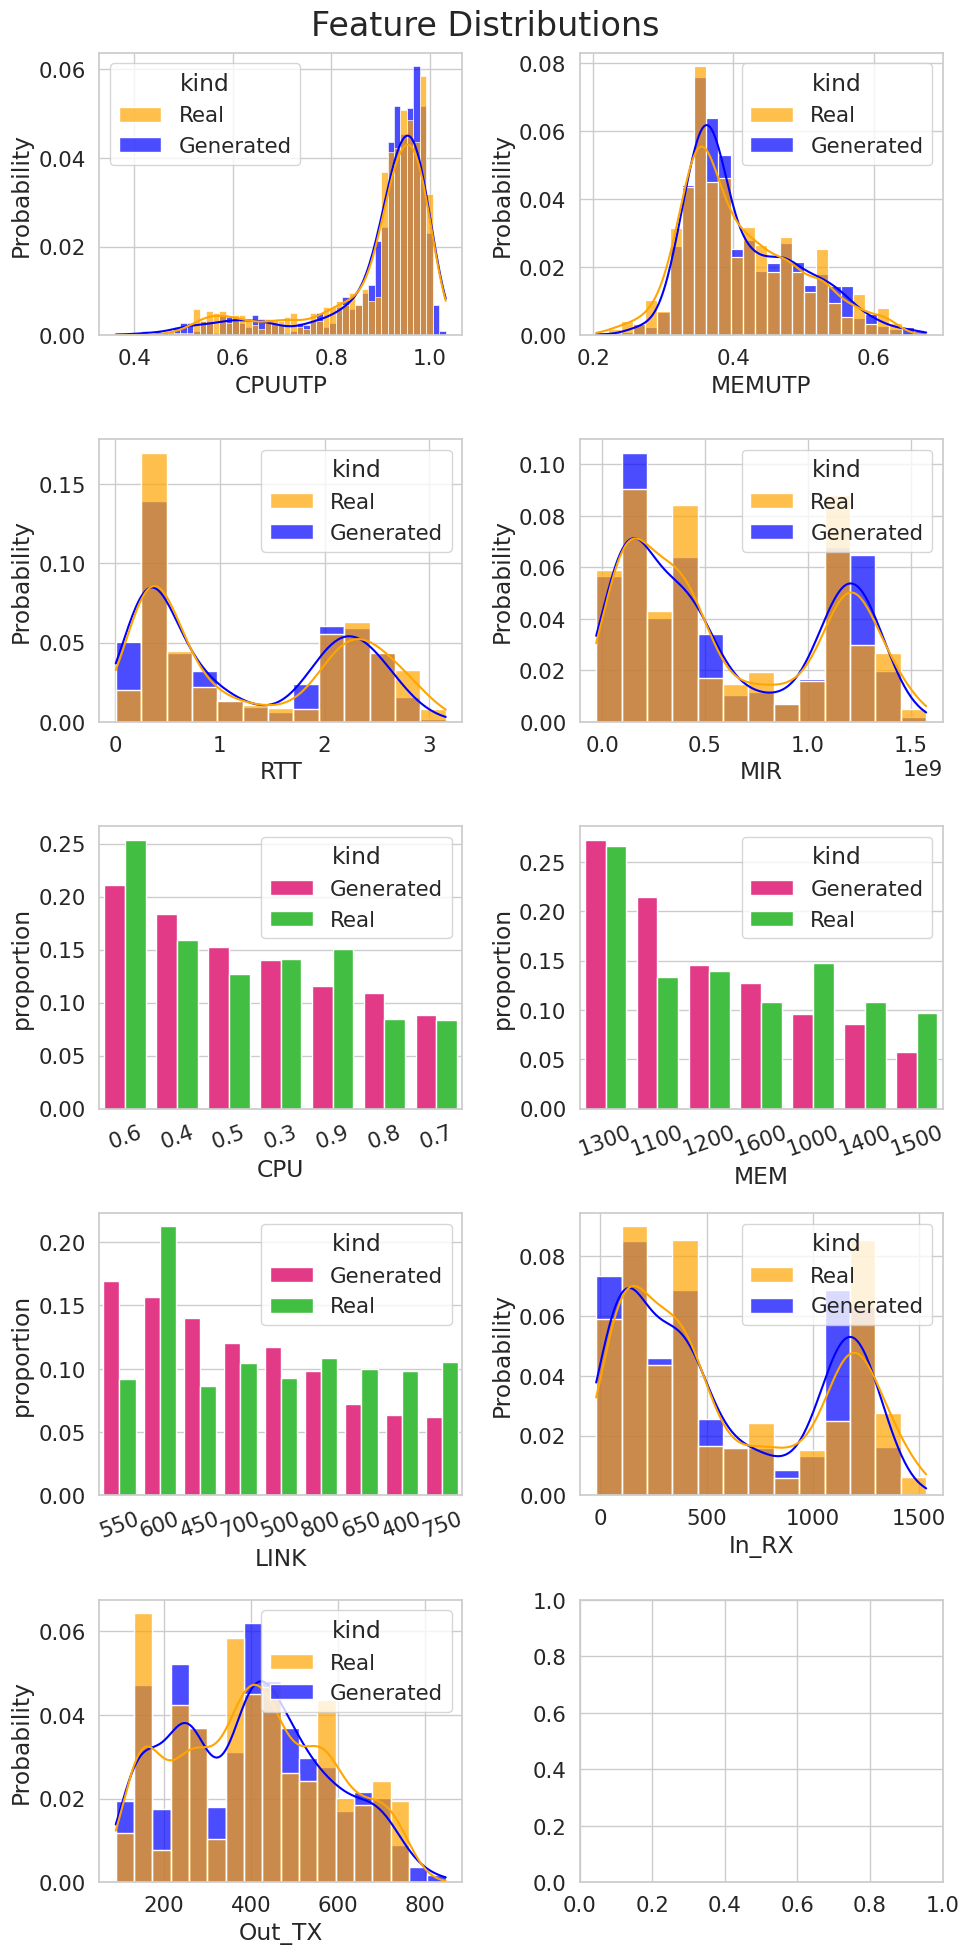

In [39]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
table_evaluator2.plot_distributions()

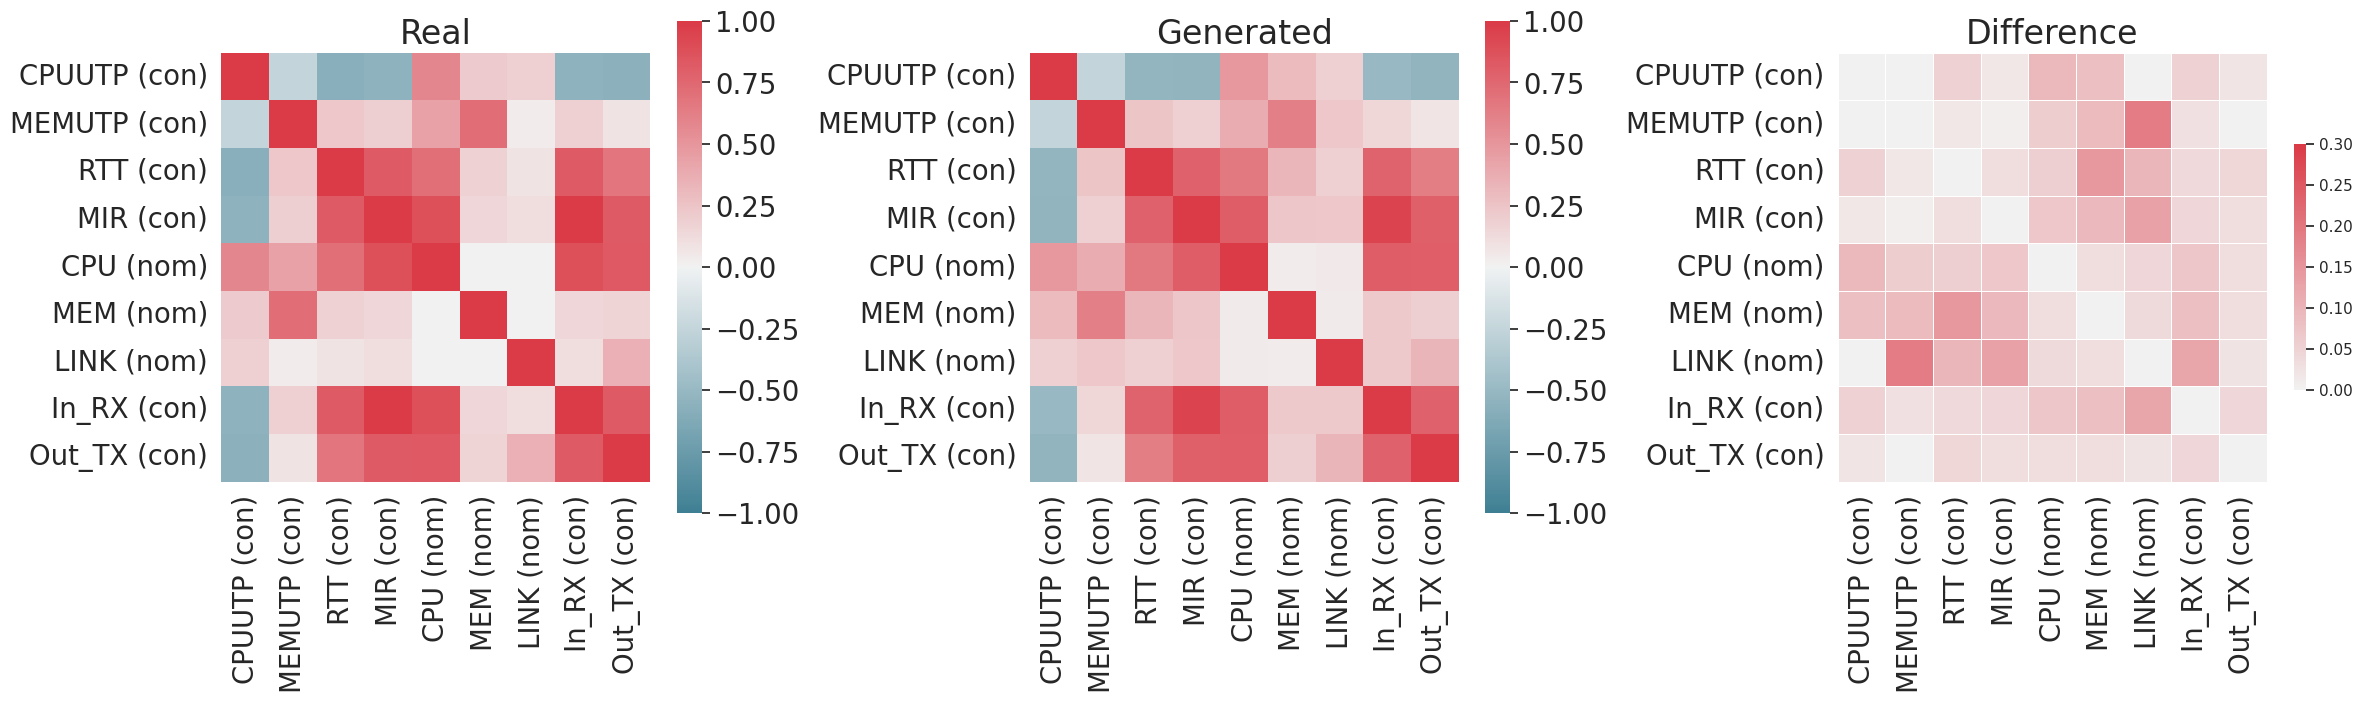

In [ ]:
sns.set(font_scale=1.8)
table_evaluator2.plot_correlation_difference()

In [ ]:
#!pip install ctgan

In [ ]:
from ctgan import CTGAN
import pandas as pd

data = pd.read_csv("/home/ubuntu/TabularVNFGAN/vFW.csv")

In [ ]:
print (data.shape)
print (data.tail())
print (data.columns)

(895, 9)
       CPUUTP  MEMUTP     RTT         MIR  CPU   MEM  LINK        In_RX  \
890  0.532222  0.2727  2.1502  4800000000  0.9  1600   600  1036.000000   
891  0.497778  0.2486  2.0852  1500000000  0.9  1600   650   937.000000   
892  0.374074  0.2462  2.4812  1574951171  0.9  1600   700  1012.000000   
893  0.516991  0.2519  2.3953  1720817057  0.9  1600   750  1024.333333   
894  0.605833  0.2396  2.7290  2400000000  0.9  1600   800  1036.000000   

         Out_TX  
890  566.000000  
891  613.000000  
892  654.000000  
893  681.666667  
894  747.000000  
Index(['CPUUTP', 'MEMUTP', 'RTT', 'MIR', 'CPU', 'MEM', 'LINK', 'In_RX',
       'Out_TX'],
      dtype='object')


In [ ]:
data.head()

,CPUUTP,MEMUTP,RTT,MIR,CPU,MEM,LINK,In_RX,Out_TX
0,0.902222,0.2527,1.2976,1000000000,0.3,1000,400,443.0,380.0
1,0.955556,0.3745,0.8838,1265625000,0.3,1000,400,705.0,379.0
2,0.930470,0.2546,0.2980,1062500000,0.3,1000,450,505.0,425.0
3,0.973333,0.3852,0.3778,1050000000,0.3,1000,450,493.0,429.0
4,0.976667,0.2561,1.0572,1062500000,0.3,1000,500,505.0,474.0


In [ ]:
# discrete_columns = ['CPUUTP', 'MEMUTP', 'RTT', 'MIR', 'CPU', 'MEM', 'LINK', 'In_RX','Out_TX']
# ctgan = CTGAN(batch_size=50,epochs=4,verbose=False)
# ctgan.fit(data,discrete_columns)
# ctgan.save('ctgan-inline-demand.pkl')
# samples = ctgan.sample(1000)
# samples.head()

,CPUUTP,MEMUTP,RTT,MIR,CPU,MEM,LINK,In_RX,Out_TX
0,0.474815,0.5171,0.5658,1.507812e+08,0.8,1500,700,209.0,562.0
1,0.989028,0.3933,2.9844,4.229167e+08,0.7,1100,400,801.0,333.0
2,0.860000,0.4862,0.3086,8.512500e+08,0.9,1100,550,1285.0,432.0
3,0.944444,0.3033,2.8000,1.150000e+09,0.7,1300,600,1226.0,690.0
4,0.882593,0.3163,2.3924,1.325000e+09,0.6,1400,700,1272.0,382.0


In [ ]:
# print (samples.shape)
# print (samples.tail())
# print (samples.columns)

(1000, 9)
       CPUUTP  MEMUTP     RTT           MIR  CPU   MEM  LINK   In_RX  Out_TX
995  0.867778  0.3907  0.6818  1.129167e+09  0.9  1300   650  1384.0   519.0
996  0.934667  0.3573  0.3670  4.562500e+08  0.6  1000   650  1402.0   584.0
997  0.925000  0.3003  2.1020  9.312500e+08  0.9  1000   400   395.0   437.0
998  0.959167  0.3284  1.1188  1.300000e+09  0.6  1200   400   989.0   257.0
999  0.911852  0.3872  2.7612  1.220312e+09  0.8  1300   600  1272.0   110.0
Index(['CPUUTP', 'MEMUTP', 'RTT', 'MIR', 'CPU', 'MEM', 'LINK', 'In_RX',
       'Out_TX'],
      dtype='object')


In [ ]:
==========================================

In [ ]:
data.columns

Index(['CPUUTP', 'MEMUTP', 'RTT', 'MIR', 'CPU', 'MEM', 'LINK', 'In_RX',
       'Out_TX'],
      dtype='object')

==============================================

In [ ]:
# # Load data
# data = pd.read_csv("/home/ubuntu/TabularVNFGAN/Inline.csv")
# num_cols = ['CPUUTP','MIR','MEMUTP','RTT']
# cat_cols = ['CPU', 'MEM', 'LINK']

In [ ]:
# Import libraries
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
from ctgan import CTGAN
from ctgan.synthesizers.ctgan import Generator

# Import training Data
data = pd.read_csv("/home/ubuntu/TabularVNFGAN/vFW.csv")

# Declare Categorical Columns
categorical_features = ['CPU', 'MEM', 'LINK']

# Declare Continuous Columns
#continuous_cols = ['CPUUTP','MIR','MEMUTP','RTT','In_RX','Out_TX']
continuous_cols = ['CPUUTP','MIR','MEMUTP','RTT']

# Train Model
from ctgan import CTGAN

ctgan = CTGAN(verbose=True)
ctgan.fit(data, categorical_features, epochs=9000)



/home/ubuntu/.local/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' param

Epoch 1, Loss G:  2.0462,Loss D: -0.0325
Epoch 2, Loss G:  2.0276,Loss D:  0.0058
Epoch 3, Loss G:  2.0700,Loss D: -0.0067
Epoch 4, Loss G:  2.0332,Loss D: -0.0293
Epoch 5, Loss G:  2.0167,Loss D: -0.0253
Epoch 6, Loss G:  2.0443,Loss D: -0.0234
Epoch 7, Loss G:  2.0423,Loss D: -0.0081
Epoch 8, Loss G:  1.9937,Loss D: -0.0249
Epoch 9, Loss G:  2.0034,Loss D: -0.0427
Epoch 10, Loss G:  1.9834,Loss D: -0.0235
Epoch 11, Loss G:  1.9554,Loss D: -0.0541
Epoch 12, Loss G:  1.9389,Loss D: -0.0443
Epoch 13, Loss G:  1.8858,Loss D: -0.0330
Epoch 14, Loss G:  1.8806,Loss D: -0.0319
Epoch 15, Loss G:  1.8520,Loss D: -0.0209
Epoch 16, Loss G:  1.8495,Loss D: -0.0414
Epoch 17, Loss G:  1.8238,Loss D: -0.0755
Epoch 18, Loss G:  1.7451,Loss D:  0.0044
Epoch 19, Loss G:  1.7936,Loss D:  0.0366
Epoch 20, Loss G:  1.7686,Loss D: -0.0265
Epoch 21, Loss G:  1.7464,Loss D: -0.0100
Epoch 22, Loss G:  1.6955,Loss D:  0.0438
Epoch 23, Loss G:  1.6128,Loss D: -0.0519
Epoch 24, Loss G:  1.5478,Loss D:  0.0481
E

In [ ]:
# Generate synthetic_data
#ctgan.save('ctgan-inline-demand.pkl')
synthetic_data = ctgan.sample(1800)
synthetic_data.to_csv('/home/ubuntu/TabularVNFGAN/vFW/vFW_generated.csv')
synthetic_data.head()

,CPUUTP,MEMUTP,RTT,MIR,CPU,MEM,LINK,In_RX,Out_TX
0,0.901113,0.296794,2.571542,5317853929,0.5,1400,750,1501.466086,720.625506
1,0.974339,0.270900,1.701660,1637900404,0.4,1600,600,633.118353,707.496745
2,0.188114,0.258807,1.837775,1581439467,0.5,1500,600,470.705357,537.840099
3,0.993258,0.354158,0.476286,1405031227,0.5,1000,650,336.006760,620.264945
4,0.573820,0.262170,1.884231,3342041780,0.8,1500,500,1190.208016,451.485790


(895, 9) (1800, 9)


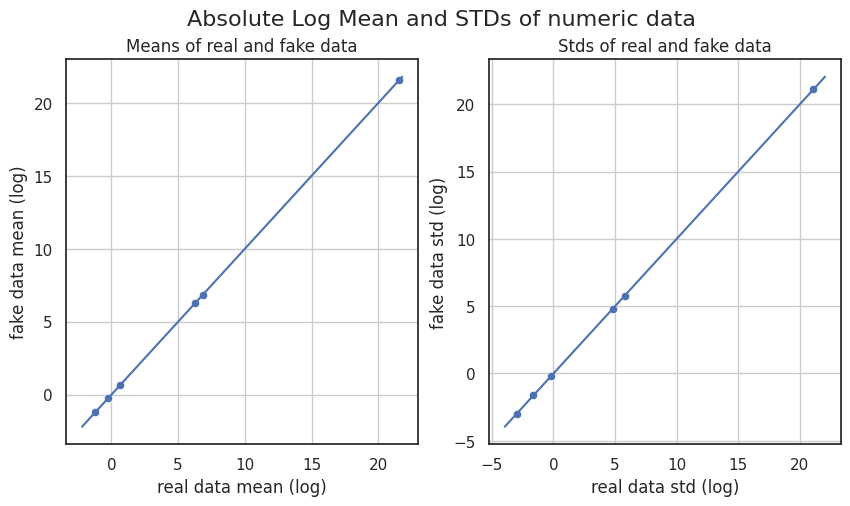

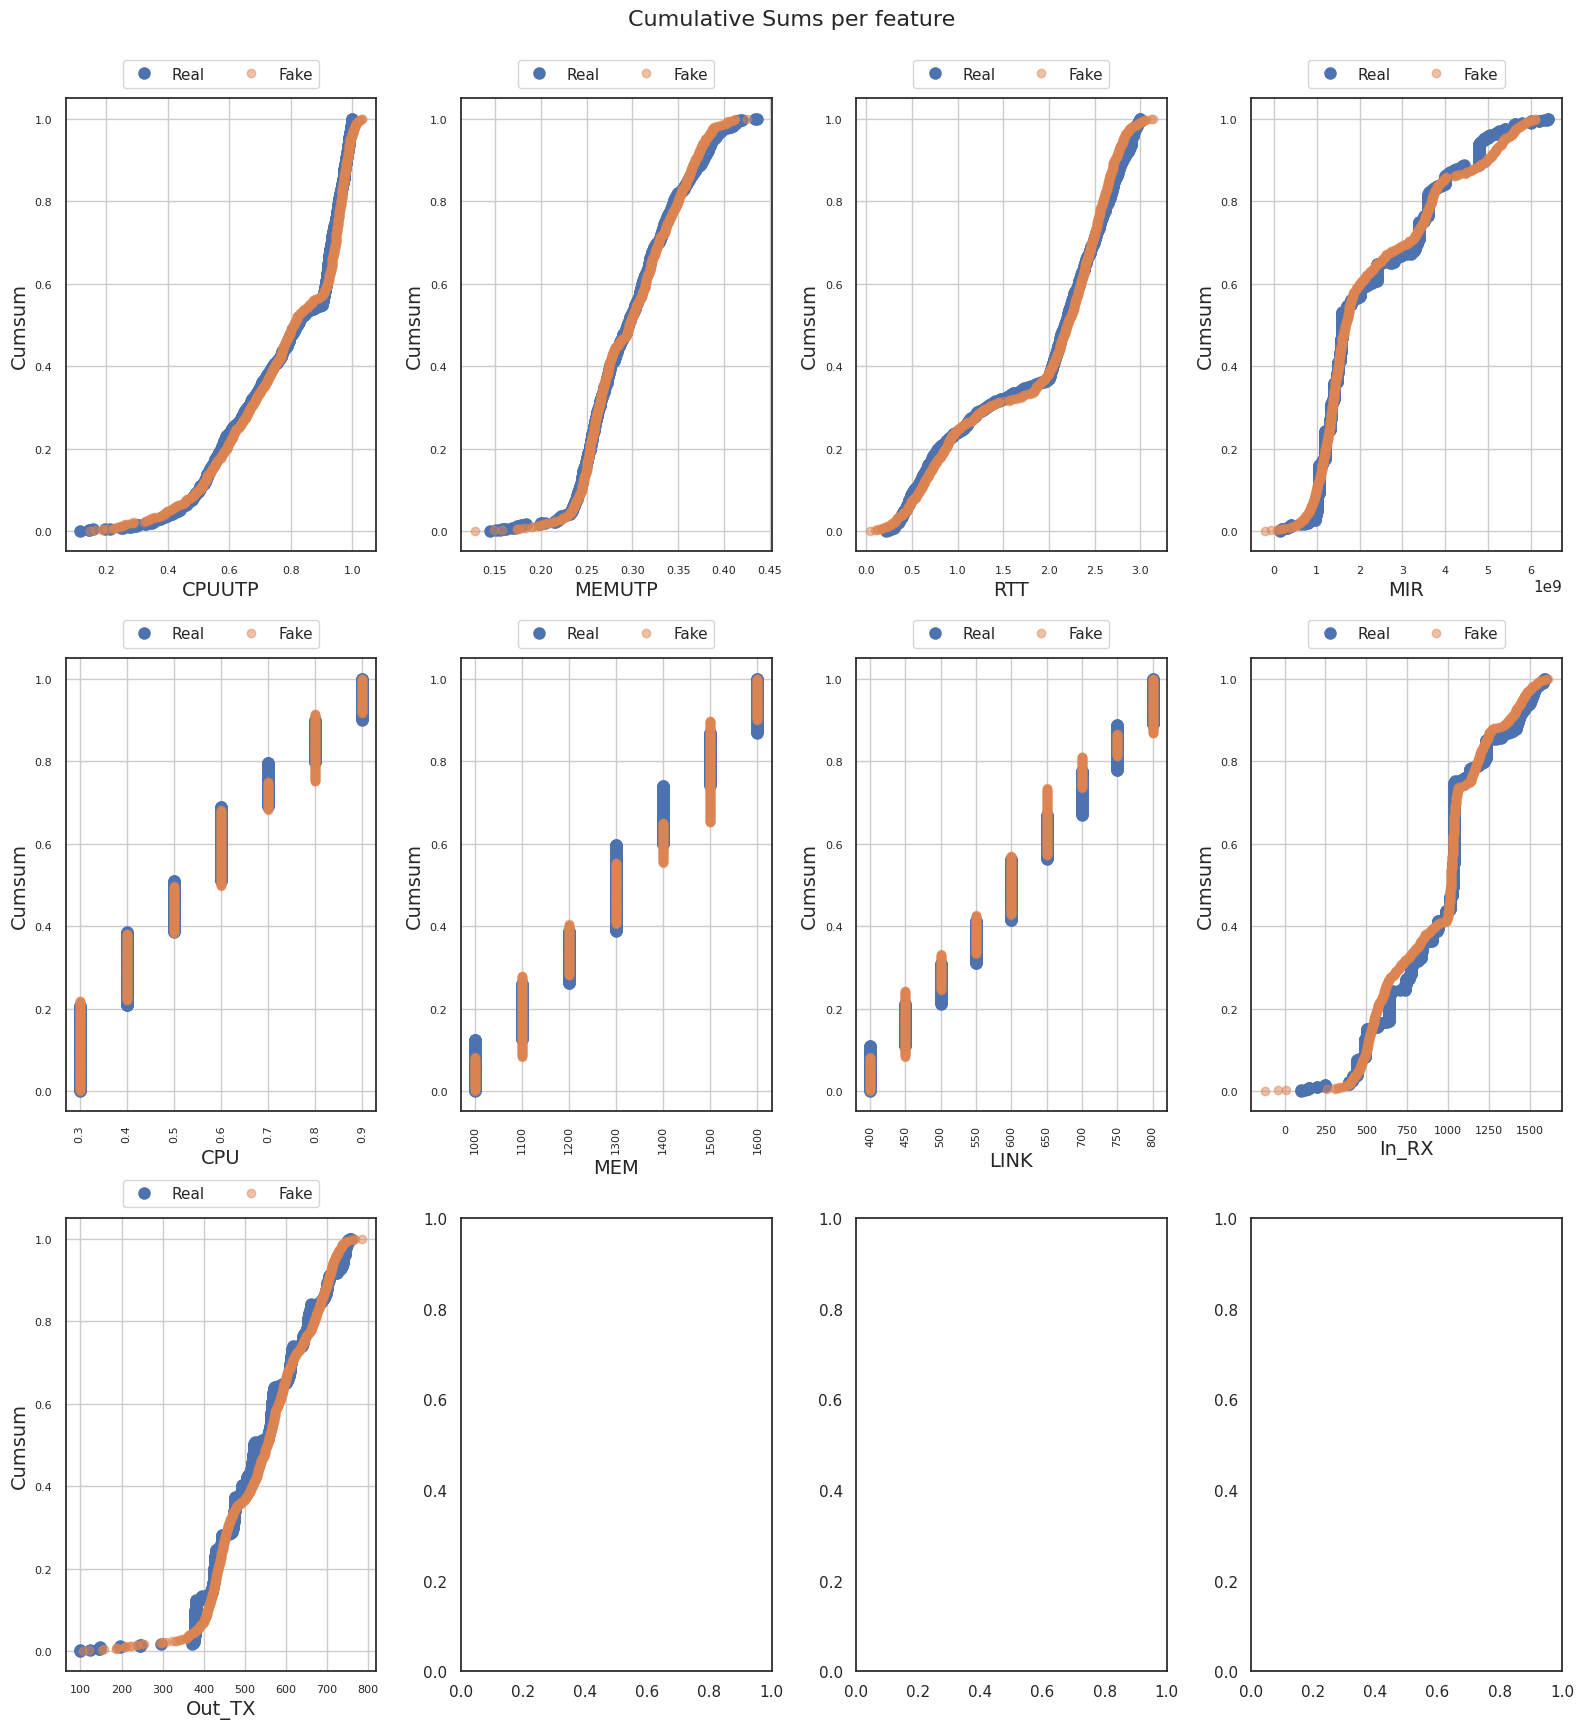

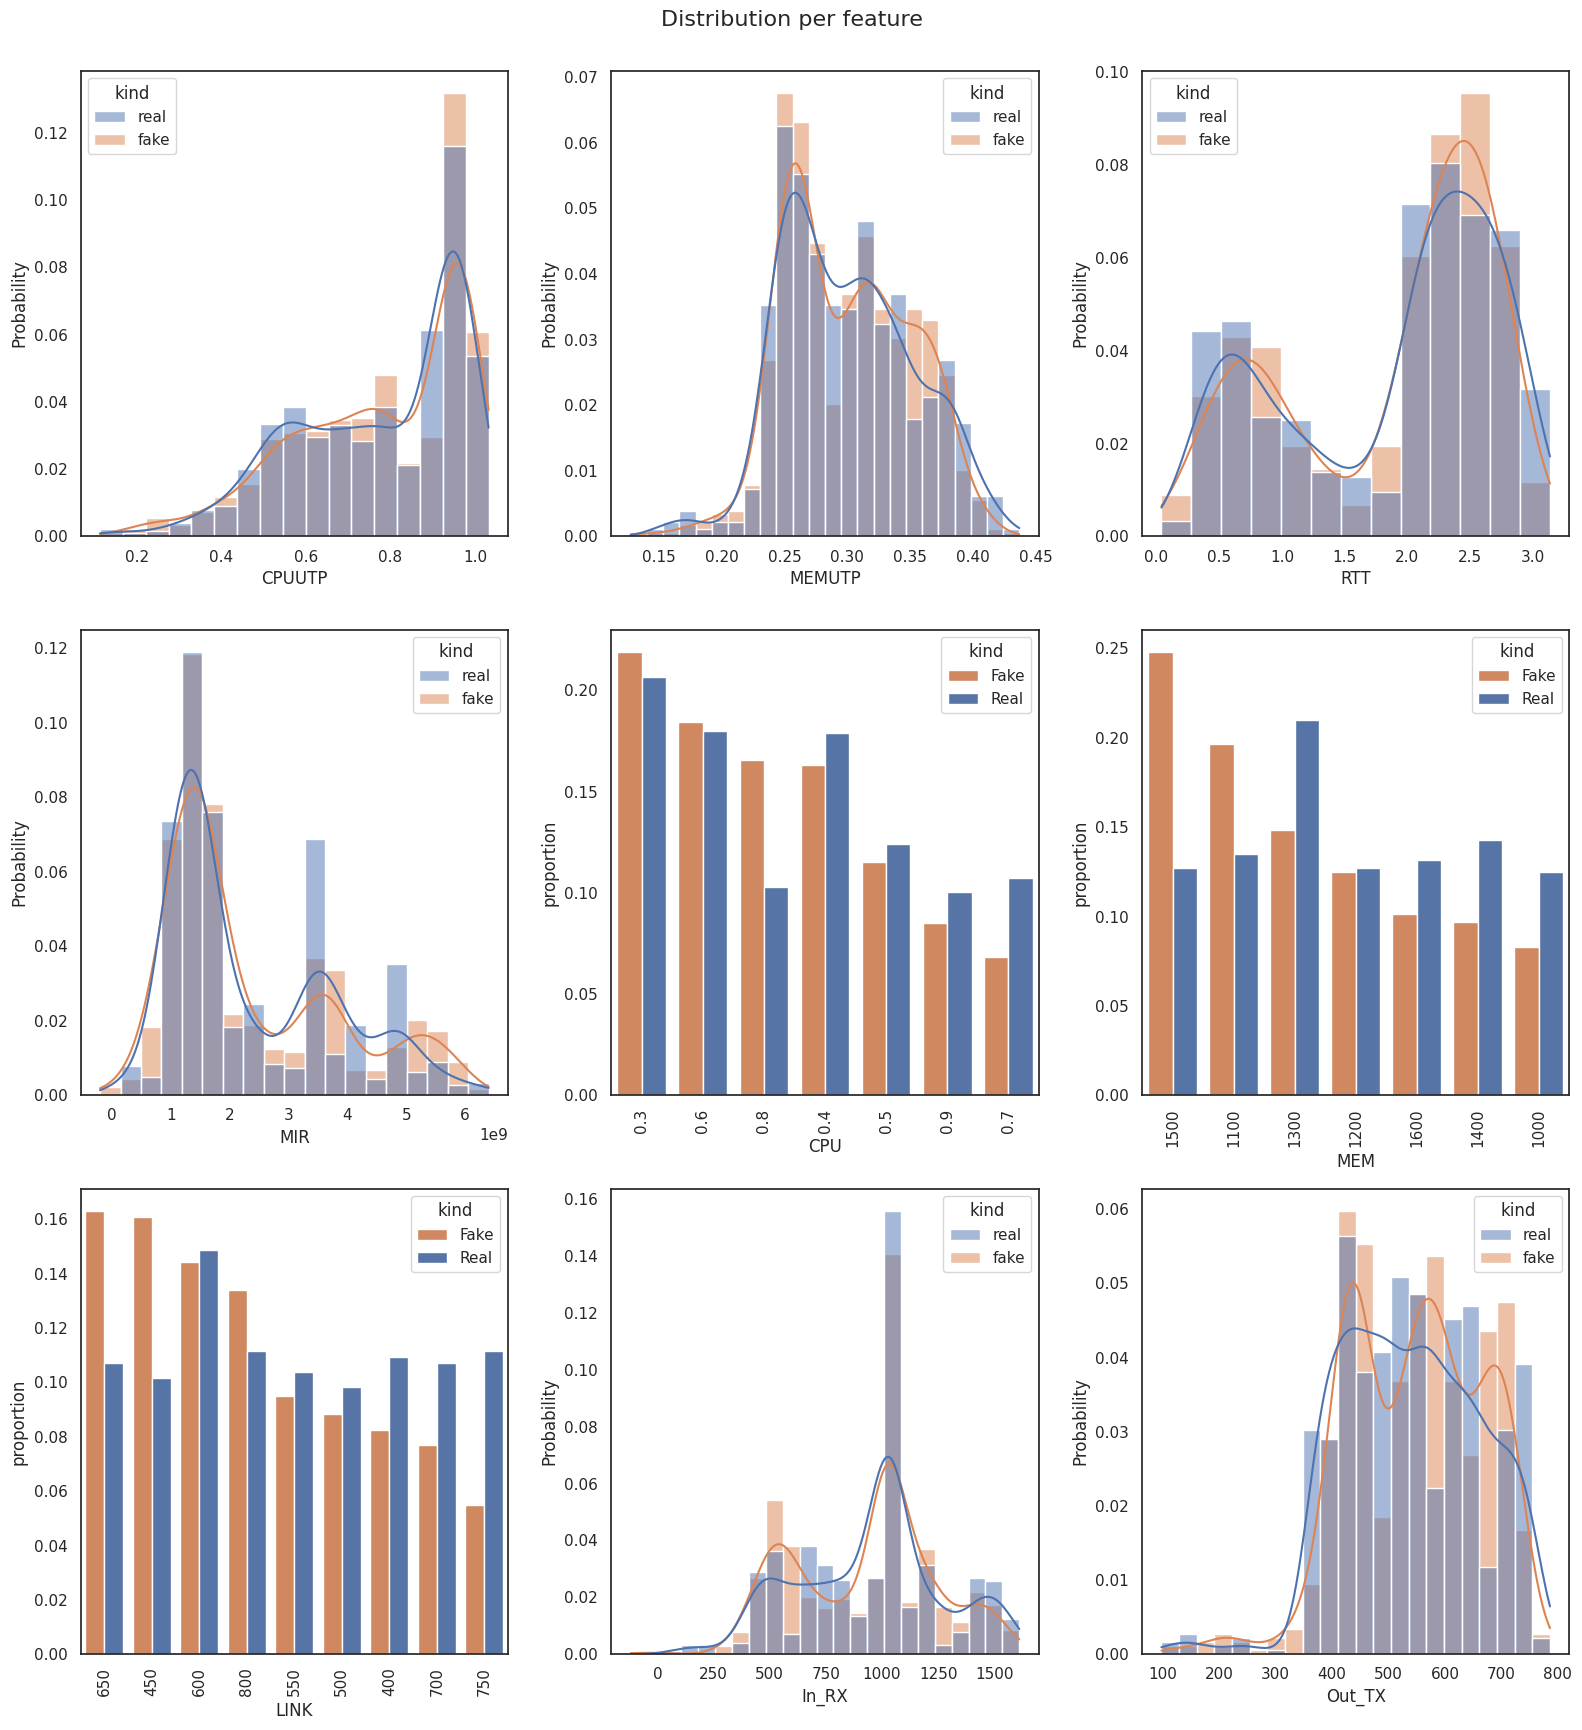

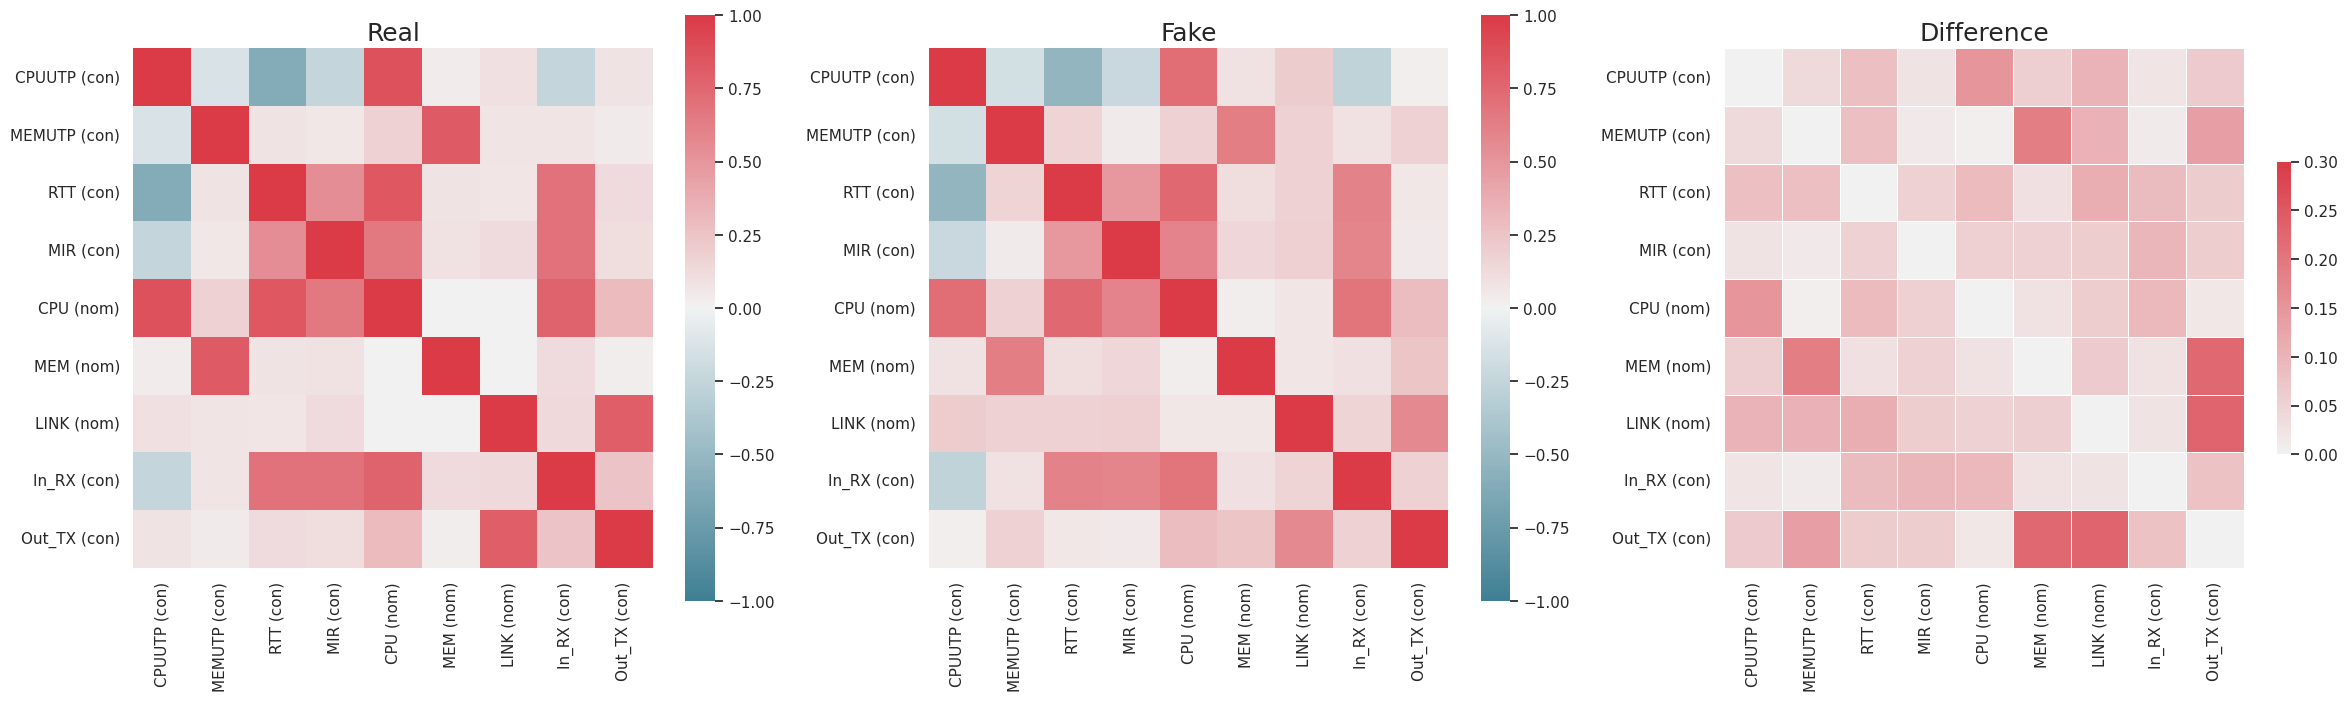

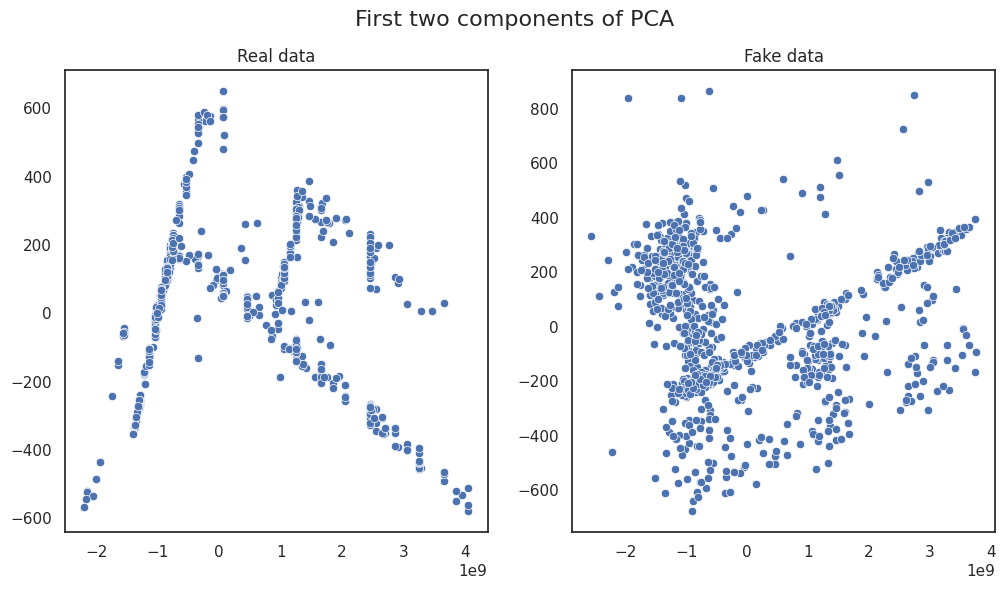

            CPUUTP       MEMUTP          RTT           MIR          CPU  \
count  1800.000000  1800.000000  1800.000000  1.800000e+03  1800.000000   
mean      0.776938     0.300227     1.874229  2.362321e+09     0.554944   
std       0.198178     0.049831     0.808451  1.453453e+09     0.199410   
min       0.001790     0.127899    -0.020255 -2.056177e+08     0.300000   
25%       0.621807     0.258335     1.021270  1.294567e+09     0.400000   
50%       0.809022     0.298228     2.178224  1.666479e+09     0.500000   
75%       0.954812     0.339948     2.514438  3.524255e+09     0.700000   
max       1.031893     0.424694     3.136223  6.348478e+09     0.900000   

               MEM         LINK        In_RX       Out_TX  
count  1800.000000  1800.000000  1800.000000  1800.000000  
mean   1308.555556   600.527778   934.247584   553.106672  
std     192.563590   126.222755   316.100998   115.148368  
min    1000.000000   400.000000  -119.263319   106.441198  
25%    1100.000000   500

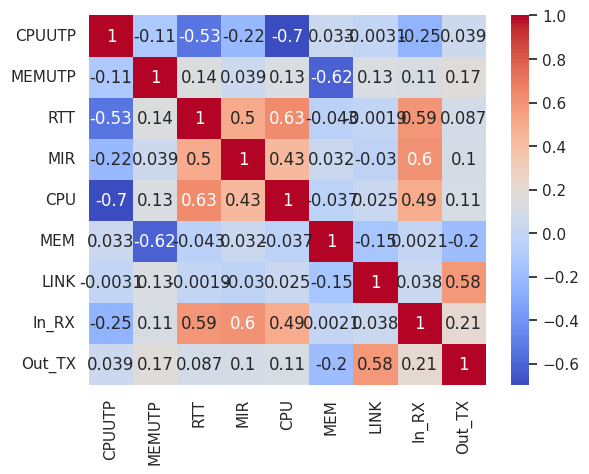

In [ ]:
# Analyze Synthetic Data
from table_evaluator import TableEvaluator

print(data.shape, synthetic_data.shape)
table_evaluator = TableEvaluator(data, synthetic_data, cat_cols=categorical_features)
table_evaluator.visual_evaluation(save_dir='/home/ubuntu/TabularVNFGAN/vFW')
# compute the correlation matrix
corr = synthetic_data.corr()

# plot the heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm")

# show summary statistics SYNTHETIC DATA
summary = synthetic_data.describe()
print(summary)

In [ ]:
!pip install dython

In [ ]:
import copy
import os
import warnings
from pathlib import Path
from typing import Dict, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dython.nominal import associations, numerical_encoding
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNet, Lasso, LogisticRegression, Ridge
from sklearn.metrics import f1_score, jaccard_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

from metrics import *
from notebook import EvaluationResult, isnotebook, visualize_notebook
from utils import dict_to_df
from viz import *


class TableEvaluator:
    """
    Class for evaluating synthetic data. It is given the real and fake data and allows the user to easily evaluate data with the `evaluate` method.
    Additional evaluations can be done with the different methods of evaluate and the visual evaluation method.
    """

    def __init__(self, real: pd.DataFrame, fake: pd.DataFrame, cat_cols=None, unique_thresh=0, metric='pearsonr',
                 verbose=False, n_samples=None, name: str = None, seed=1337):
        """
        :param real: Real dataset (pd.DataFrame)
        :param fake: Synthetic dataset (pd.DataFrame)
        :param unique_thresh: Threshold for automatic evaluation if column is numeric
        :param cat_cols: The columns that are to be evaluated as discrete. If passed, unique_thresh is ignored.
        :param metric: the metric to use for evaluation linear relations. Pearson's r by default, but supports all models in scipy.stats
        :param verbose: Whether to print verbose output
        :param n_samples: Number of samples to evaluate. If none, it will take the minimal length of both datasets and cut the larger one off to make sure they
            are the same length.
        :param name: Name of the TableEvaluator. Used in some plotting functions like `viz.plot_correlation_comparison` to indicate your model.
        """
        self.name = name
        self.unique_thresh = unique_thresh
        self.real = real.copy()
        self.fake = fake.copy()
        self.comparison_metric = getattr(stats, metric)
        self.verbose = verbose
        self.random_seed = seed

        # Make sure columns and their order are the same.
        if len(real.columns) == len(fake.columns):
            fake = fake[real.columns.tolist()]
        assert real.columns.tolist() == fake.columns.tolist(), 'Columns in real and fake dataframe are not the same'

        if cat_cols is None:
            real = real.infer_objects()
            fake = fake.infer_objects()
            self.numerical_columns = [column for column in real.select_dtypes(include='number').columns if
                                      len(real[column].unique()) > unique_thresh]
            self.categorical_columns = [column for column in real.columns if column not in self.numerical_columns]
        else:
            self.categorical_columns = cat_cols
            self.numerical_columns = [column for column in real.columns if column not in cat_cols]

        # Make sure the number of samples is equal in both datasets.
        if n_samples is None:
            self.n_samples = min(len(self.real), len(self.fake))
        elif len(fake) >= n_samples and len(real) >= n_samples:
            self.n_samples = n_samples
        else:
            raise Exception(f'Make sure n_samples < len(fake/real). len(real): {len(real)}, len(fake): {len(fake)}')

        self.real = self.real.sample(self.n_samples)
        self.fake = self.fake.sample(self.n_samples)
        assert len(self.real) == len(self.fake), f'len(real) != len(fake)'

        self.real.loc[:, self.categorical_columns] = self.real.loc[:, self.categorical_columns].fillna('[NAN]').astype(
            str)
        self.fake.loc[:, self.categorical_columns] = self.fake.loc[:, self.categorical_columns].fillna('[NAN]').astype(
            str)

        self.real.loc[:, self.numerical_columns] = self.real.loc[:, self.numerical_columns].fillna(
            self.real[self.numerical_columns].mean())
        self.fake.loc[:, self.numerical_columns] = self.fake.loc[:, self.numerical_columns].fillna(
            self.fake[self.numerical_columns].mean())

    def plot_mean_std(self, fname=None):
        """
        Class wrapper function for plotting the mean and std using `viz.plot_mean_std`.
        :param fname: If not none, saves the plot with this file name.
        """
        plot_mean_std(self.real, self.fake, fname=fname)

    def plot_cumsums(self, nr_cols=4, fname=None):
        """
        Plot the cumulative sums for all columns in the real and fake dataset. Height of each row scales with the length of the labels. Each plot contains the
        values of a real columns and the corresponding fake column.
        :param fname: If not none, saves the plot with this file name.
        """
        nr_charts = len(self.real.columns)
        nr_rows = max(1, nr_charts // nr_cols)
        nr_rows = nr_rows + 1 if nr_charts % nr_cols != 0 else nr_rows

        max_len = 0
        # Increase the length of plots if the labels are long
        if not self.real.select_dtypes(include=['object']).empty:
            lengths = []
            for d in self.real.select_dtypes(include=['object']):
                lengths.append(max([len(x.strip()) for x in self.real[d].unique().tolist()]))
            max_len = max(lengths)

        row_height = 6 + (max_len // 30)
        fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(16, row_height * nr_rows))
        fig.suptitle('Cumulative Sums per feature', fontsize=16)
        axes = ax.flatten()
        for i, col in enumerate(self.real.columns):
            try:
                r = self.real[col]
                f = self.fake.iloc[:, self.real.columns.tolist().index(col)]
                cdf(r, f, col, 'Cumsum', ax=axes[i])
            except Exception as e:
                print(f'Error while plotting column {col}')
                raise e

        plt.tight_layout(rect=[0, 0.02, 1, 0.98])

        if fname is not None:
            plt.savefig(fname)

        plt.show()

    def plot_distributions(self, nr_cols=3, fname=None):
        """
        Plot the distribution plots for all columns in the real and fake dataset. Height of each row of plots scales with the length of the labels. Each plot
        contains the values of a real columns and the corresponding fake column.
        :param fname: If not none, saves the plot with this file name.
        """
        nr_charts = len(self.real.columns)
        nr_rows = max(1, nr_charts // nr_cols)
        nr_rows = nr_rows + 1 if nr_charts % nr_cols != 0 else nr_rows

        max_len = 0
        # Increase the length of plots if the labels are long
        if not self.real.select_dtypes(include=['object']).empty:
            lengths = []
            for d in self.real.select_dtypes(include=['object']):
                lengths.append(max([len(x.strip()) for x in self.real[d].unique().tolist()]))
            max_len = max(lengths)

        row_height = 6 + (max_len // 30)
        fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(16, row_height * nr_rows))
        fig.suptitle('Distribution per feature', fontsize=16)
        axes = ax.flatten()
        for i, col in enumerate(self.real.columns):
            if col not in self.categorical_columns:
                plot_df = pd.DataFrame({col: pd.concat([self.real[col], self.fake[col]], axis=0), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
                fig = sns.histplot(plot_df, x=col, hue='kind', ax=axes[i], stat='probability', legend=True, kde=True)
                axes[i].set_autoscaley_on(True)
            else:
                real = self.real.copy()
                fake = self.fake.copy()
                real['kind'] = 'Real'
                fake['kind'] = 'Fake'
                concat = pd.concat([fake, real])
                palette = sns.color_palette(
                    [(0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
                     (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)])
                x, y, hue = col, "proportion", "kind"
                ax = (concat[x]
                      .groupby(concat[hue])
                      .value_counts(normalize=True)
                      .rename(y)
                      .reset_index()
                      .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, ax=axes[i], saturation=0.8, palette=palette))
                ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])

        if fname is not None:
            plt.savefig(fname)

        plt.show()

    def plot_correlation_difference(self, plot_diff=True, fname=None, **kwargs):
        """
        Plot the association matrices for each table and, if chosen, the difference between them.

        :param plot_diff: whether to plot the difference
        :param fname: If not none, saves the plot with this file name.
        :param kwargs: kwargs for sns.heatmap
        """
        plot_correlation_difference(self.real, self.fake, cat_cols=self.categorical_columns, plot_diff=plot_diff, fname=fname,
                                    **kwargs)

    def correlation_distance(self, how: str = 'euclidean') -> float:
        """
        Calculate distance between correlation matrices with certain metric.

        :param how: metric to measure distance. Choose from [``euclidean``, ``mae``, ``rmse``].
        :return: distance between the association matrices in the chosen evaluation metric. Default: Euclidean
        """
        from scipy.spatial.distance import cosine
        if how == 'euclidean':
            distance_func = euclidean_distance
        elif how == 'mae':
            distance_func = mean_absolute_error
        elif how == 'rmse':
            distance_func = rmse
        elif how == 'cosine':
            def custom_cosine(a, b):
                return cosine(a.reshape(-1), b.reshape(-1))

            distance_func = custom_cosine
        else:
            raise ValueError(f'`how` parameter must be in [euclidean, mae, rmse]')

        real_corr = associations(self.real, nominal_columns=self.categorical_columns, nom_nom_assoc='theil', compute_only=True)['corr'] # type: ignore
        fake_corr = associations(self.fake, nominal_columns=self.categorical_columns, nom_nom_assoc='theil', compute_only=True)['corr'] # type: ignore
        return distance_func(
            real_corr.values,
            fake_corr.values
        ) # type: ignore


    def get_copies(self, return_len: bool = False) -> Union[pd.DataFrame, int]:
        """
        Check whether any real values occur in the fake data.

        :param return_len: whether to return the length of the copied rows or not.
        :return: Dataframe containing the duplicates if return_len=False, else integer indicating the number of copied rows.
        """
        real_hashes = self.real.apply(lambda x: hash(tuple(x)), axis=1)
        fake_hashes = self.fake.apply(lambda x: hash(tuple(x)), axis=1)

        dup_idxs = fake_hashes.isin(real_hashes.values)
        dup_idxs = dup_idxs[dup_idxs == True].sort_index().index.tolist()

        if self.verbose:
            print(f'Nr copied columns: {len(dup_idxs)}')
        copies = self.fake.loc[dup_idxs, :]

        if return_len:
            return len(copies)
        else:
            return copies

    def get_duplicates(self, return_values: bool = False) -> Tuple[Union[pd.DataFrame, int], Union[pd.DataFrame, int]]:
        """
        Return duplicates within each dataset.

        :param return_values: whether to return the duplicate values in the datasets. If false, the lengths are returned.
        :return: dataframe with duplicates or the length of those dataframes if return_values=False.
        """
        real_duplicates = self.real[self.real.duplicated(keep=False)]
        fake_duplicates = self.fake[self.fake.duplicated(keep=False)]
        if return_values:
            return real_duplicates, fake_duplicates
        else:
            return len(real_duplicates), len(fake_duplicates)

    def pca_correlation(self, lingress=False):
        """
        Calculate the relation between PCA explained variance values. Due to some very large numbers, in recent implementation the MAPE(log) is used instead of
        regressions like Pearson's r.

        :param lingress: whether to use a linear regression, in this case Pearson's.
        :return: the correlation coefficient if lingress=True, otherwise 1 - MAPE(log(real), log(fake))
        """
        self.pca_r = PCA(n_components=5)
        self.pca_f = PCA(n_components=5)

        real, fake = self.convert_numerical()

        self.pca_r.fit(real)
        self.pca_f.fit(fake)
        if self.verbose:
            results = pd.DataFrame({'real': self.pca_r.explained_variance_, 'fake': self.pca_f.explained_variance_})
            print(f'\nTop 5 PCA components:')
            print(results.to_string())

        if lingress:
            corr, p, _ = self.comparison_metric(self.pca_r.explained_variance_, self.pca_f.explained_variance_)
            return corr
        else:
            pca_error = mean_absolute_percentage_error(self.pca_r.explained_variance_, self.pca_f.explained_variance_)
            return 1 - pca_error

    def fit_estimators(self):
        """
        Fit self.r_estimators and self.f_estimators to real and fake data, respectively.
        """

        if self.verbose:
            print(f'\nFitting real')
        for i, c in enumerate(self.r_estimators):
            if self.verbose:
                print(f'{i + 1}: {type(c).__name__}')
            c.fit(self.real_x_train, self.real_y_train)

        if self.verbose:
            print(f'\nFitting fake')
        for i, c in enumerate(self.f_estimators):
            if self.verbose:
                print(f'{i + 1}: {type(c).__name__}')
            c.fit(self.fake_x_train, self.fake_y_train)

    def score_estimators(self):
        """
        Get F1 scores of self.r_estimators and self.f_estimators on the fake and real data, respectively.

        :return: dataframe with the results for each estimator on each data test set.
        """
        if self.target_type == 'class':
            rows = []
            for r_classifier, f_classifier, estimator_name in zip(self.r_estimators, self.f_estimators,
                                                                  self.estimator_names):
                for dataset, target, dataset_name in zip([self.real_x_test, self.fake_x_test],
                                                         [self.real_y_test, self.fake_y_test], ['real', 'fake']):
                    predictions_classifier_real = r_classifier.predict(dataset)
                    predictions_classifier_fake = f_classifier.predict(dataset)
                    f1_r = f1_score(target, predictions_classifier_real, average='micro')
                    f1_f = f1_score(target, predictions_classifier_fake, average='micro')
                    jac_sim = jaccard_score(predictions_classifier_real, predictions_classifier_fake, average='micro')
                    row = {'index': f'{estimator_name}_{dataset_name}', 'f1_real': f1_r, 'f1_fake': f1_f,
                           'jaccard_similarity': jac_sim}
                    rows.append(row)
            results = pd.DataFrame(rows).set_index('index')

        elif self.target_type == 'regr':
            r2r = [rmse(self.real_y_test, clf.predict(self.real_x_test)) for clf in self.r_estimators]
            f2f = [rmse(self.fake_y_test, clf.predict(self.fake_x_test)) for clf in self.f_estimators]

            # Calculate test set accuracies on the other dataset
            r2f = [rmse(self.fake_y_test, clf.predict(self.fake_x_test)) for clf in self.r_estimators]
            f2r = [rmse(self.real_y_test, clf.predict(self.real_x_test)) for clf in self.f_estimators]
            index = [f'real_data_{classifier}' for classifier in self.estimator_names] + \
                    [f'fake_data_{classifier}' for classifier in self.estimator_names]
            results = pd.DataFrame({'real': r2r + f2r, 'fake': r2f + f2f}, index=index)
        else:
            raise Exception(f'self.target_type should be either \'class\' or \'regr\', but is {self.target_type}.')
        return results

    def visual_evaluation(self, save_dir=None, **kwargs):
        """
        Plot all visual evaluation metrics. Includes plotting the mean and standard deviation, cumulative sums, correlation differences and the PCA transform.
        :save_dir: directory path to save images
        :param kwargs: any kwargs for matplotlib.
        """
        if save_dir is None:
            self.plot_mean_std()
            self.plot_cumsums()
            self.plot_distributions()
            self.plot_correlation_difference(**kwargs)
            self.plot_pca()
        else:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)

            self.plot_mean_std(fname=save_dir/'mean_std.png')
            self.plot_cumsums(fname=save_dir/'cumsums.png')
            self.plot_distributions(fname=save_dir/'distributions.png')
            self.plot_correlation_difference(fname=save_dir/'correlation_difference.png', **kwargs)
            self.plot_pca(fname=save_dir/'pca.png')


    def basic_statistical_evaluation(self) -> float:
        """
        Calculate the correlation coefficient between the basic properties of self.real and self.fake using Spearman's Rho. Spearman's is used because these
        values can differ a lot in magnitude, and Spearman's is more resilient to outliers.

        :return: correlation coefficient
        """
        total_metrics = pd.DataFrame()
        for ds_name in ['real', 'fake']:
            ds = getattr(self, ds_name)
            metrics = {}
            # TODO: add discrete columns as factors
            num_ds = ds[self.numerical_columns]

            for idx, value in num_ds.mean().items():
                metrics[f'mean_{idx}'] = value
            for idx, value in num_ds.median().items():
                metrics[f'median_{idx}'] = value
            for idx, value in num_ds.std().items():
                metrics[f'std_{idx}'] = value
            for idx, value in num_ds.var().items():
                metrics[f'variance_{idx}'] = value
            total_metrics[ds_name] = metrics.values()

        total_metrics.index = metrics.keys()
        self.statistical_results = total_metrics
        if self.verbose:
            print('\nBasic statistical attributes:')
            print(total_metrics.to_string())
        corr, p = stats.spearmanr(total_metrics['real'], total_metrics['fake'])
        return corr

    def correlation_correlation(self) -> float:
        """
        Calculate the correlation coefficient between the association matrices of self.real and self.fake using self.comparison_metric

        :return: The correlation coefficient
        """
        total_metrics = pd.DataFrame()
        for ds_name in ['real', 'fake']:
            ds = getattr(self, ds_name)
            corr_df: pd.DataFrame = associations(ds, nominal_columns=self.categorical_columns, nom_nom_assoc='theil', compute_only=True)['corr']
            values = corr_df.values
            # print(values, type(values))
            values = values[~np.eye(values.shape[0], dtype=bool)].reshape(values.shape[0], -1)
            total_metrics[ds_name] = values.flatten()

        self.correlation_correlations = total_metrics
        corr, p = self.comparison_metric(total_metrics['real'], total_metrics['fake'])
        if self.verbose:
            print('\nColumn correlation between datasets:')
            print(total_metrics.to_string())
        return corr

    def convert_numerical(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Special function to convert dataset to a numerical representations while making sure they have identical columns. This is sometimes a problem with
        categorical columns with many values or very unbalanced values

        :return: Real and fake dataframe factorized using the pandas function
        """
        real = self.real
        fake = self.fake
        for c in self.categorical_columns:
            if real[c].dtype == 'object':
                real[c] = pd.factorize(real[c], sort=True)[0]
                fake[c] = pd.factorize(fake[c], sort=True)[0]

        return real, fake

    def convert_numerical_one_hot(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Special function to convert dataset to a numerical representations while making sure they have identical columns. This is sometimes a problem with
        categorical columns with many values or very unbalanced values

        :return: Real and fake dataframe with categorical columns one-hot encoded and binary columns factorized.
        """
        real: pd.DataFrame = numerical_encoding(self.real, nominal_columns=self.categorical_columns)
        real = real.sort_index(axis=1)
        fake: pd.DataFrame = numerical_encoding(self.fake, nominal_columns=self.categorical_columns)
        for col in real.columns:
            if col not in fake:
                fake[col] = 0
        fake = fake.sort_index(axis=1)

        # Cast True/False columns to 0/1.
        bool_cols = real.select_dtypes('bool').columns
        real[bool_cols] = real[bool_cols].astype(float)
        fake[bool_cols] = fake[bool_cols].astype(float)

        return real, fake

    def estimator_evaluation(self, target_col: str, target_type: str = 'class', kfold: bool = False) -> float:
        """
        Method to do full estimator evaluation, including training. And estimator is either a regressor or a classifier, depending on the task. Two sets are
        created of each of the estimators `S_r` and `S_f`, for the real and fake data respectively. `S_f` is trained on ``self.real`` and `S_r` on
        ``self.fake``. Then, both are evaluated on their own and the others test set. If target_type is ``regr`` we do a regression on the RMSE scores with
        Pearson's. If target_type is ``class``, we calculate F1 scores and do return ``1 - MAPE(F1_r, F1_f)``.

        :param target_col: which column should be considered the target both both the regression and classification task.
        :param target_type: what kind of task this is. Can be either ``class`` or ``regr``.
        :param kfold: if set to True, will perform 5-fold CV, otherwise will just train on 80% and test on 20% of the data once.
        :return: Correlation value or 1 - MAPE
        """
        self.target_col = target_col
        self.target_type = target_type

        # Convert both datasets to numerical representations and split x and  y
        real, fake = self.convert_numerical()

        real_x = real.drop([target_col], axis=1)
        fake_x = fake.drop([target_col], axis=1)

        assert real_x.columns.tolist() == fake_x.columns.tolist(), f'real and fake columns are different: \n{real_x.columns}\n{fake_x.columns}'

        real_y = real[target_col]
        fake_y = fake[target_col]

        # For reproducibilty:
        np.random.seed(self.random_seed)

        if target_type == 'regr':
            self.estimators = [
                RandomForestRegressor(n_estimators=20, max_depth=5, random_state=42),
                Lasso(random_state=42),
                Ridge(alpha=1.0, random_state=42),
                ElasticNet(random_state=42),
            ]
        elif target_type == 'class':
            self.estimators = [
                LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=500, random_state=42),
                RandomForestClassifier(n_estimators=10, random_state=42),
                DecisionTreeClassifier(random_state=42),
                MLPClassifier([50, 50], solver='adam', activation='relu', learning_rate='adaptive', random_state=42),
            ]
        else:
            raise ValueError(f'target_type must be \'regr\' or \'class\'')

        self.estimator_names = [type(clf).__name__ for clf in self.estimators]

        # K Fold
        kf = KFold(n_splits=5)
        res = []
        for train_index, test_index in kf.split(real_y):
            self.real_x_train = real_x.iloc[train_index]
            self.real_x_test = real_x.iloc[test_index]
            self.real_y_train = real_y.iloc[train_index]
            self.real_y_test = real_y.iloc[test_index]
            self.fake_x_train = fake_x.iloc[train_index]
            self.fake_x_test = fake_x.iloc[test_index]
            self.fake_y_train = fake_y.iloc[train_index]
            self.fake_y_test = fake_y.iloc[test_index]

            self.r_estimators = copy.deepcopy(self.estimators)
            self.f_estimators = copy.deepcopy(self.estimators)

            for estimator in self.estimators:
                assert hasattr(estimator, 'fit')
                assert hasattr(estimator, 'score')

            self.fit_estimators()
            res.append(self.score_estimators())

            # Break the loop if we don't want the kfold
            if not kfold:
                break

        self.estimators_scores = pd.concat(res).groupby(level=0).mean()
        if self.verbose:
            print('\nClassifier F1-scores and their Jaccard similarities:') if self.target_type == 'class' \
                else print('\nRegressor MSE-scores and their Jaccard similarities:')
            print(self.estimators_scores.to_string())

        if self.target_type == 'regr':
            corr, p = self.comparison_metric(self.estimators_scores['real'], self.estimators_scores['fake'])
            return corr
        elif self.target_type == 'class':
            mean = mean_absolute_percentage_error(self.estimators_scores['f1_real'], self.estimators_scores['f1_fake'])
            return 1 - mean
        else:
            raise ValueError('`self.target_type` should be `regr` or `class`.')

    def row_distance(self, n_samples: int = None) -> Tuple[np.number, np.number]:
        """
        Calculate mean and standard deviation distances between `self.fake` and `self.real`.

        :param n_samples: Number of samples to take for evaluation. Compute time increases exponentially.
        :return: `(mean, std)` of these distances.
        """
        if n_samples is None:
            n_samples = len(self.real)

        real, fake = self.convert_numerical_one_hot()

        columns = sorted(real.columns.tolist())
        real = real[columns]

        for col in columns:
            if col not in fake.columns.tolist():
                fake[col] = 0
        fake = fake[columns]

        for column in real.columns.tolist():
            if len(real[column].unique()) > 2:
                real[column] = (real[column] - real[column].mean()) / real[column].std()
                fake[column] = (fake[column] - fake[column].mean()) / fake[column].std()
        assert real.columns.tolist() == fake.columns.tolist()

        distances = cdist(real[:n_samples], fake[:n_samples])
        min_distances = np.min(distances, axis=1)
        min_mean = np.mean(min_distances)
        min_std = np.std(min_distances)
        return min_mean, min_std

    def column_correlations(self):
        """
        Wrapper function around `metrics.column_correlation`.

        :return: Column correlations between ``self.real`` and ``self.fake``.
        """

        real, fake = self.convert_numerical()

        return column_correlations(real, fake, self.categorical_columns)

    def evaluate(self, target_col: str, target_type: str = 'class', metric: str = None, verbose: bool = None,
                 n_samples_distance: int = 20000, kfold: bool = False, notebook: bool = False, return_outputs: bool = False) -> Dict:
        """
        Determine correlation between attributes from the real and fake dataset using a given metric.
        All metrics from scipy.stats are available.

        :param target_col: column to use for predictions with estimators
        :param target_type: what kind of task to perform on the target_col. Can be either ``class`` for classification or ``regr`` for regression.
        :param metric: overwrites self.metric. Scoring metric for the attributes.
            By default Pearson's r is used. Alternatives include Spearman rho (scipy.stats.spearmanr) or Kendall Tau (scipy.stats.kendalltau).
        :param n_samples_distance: The number of samples to take for the row distance. See documentation of ``tableEvaluator.row_distance`` for details.
        :param kfold: Use a 5-fold CV for the ML estimators if set to True. Train/Test on 80%/20% of the data if set to False.
        :param notebook: Better visualization of the results in a python notebook
        :param verbose: whether to print verbose logging.
        :param return_outputs: Will omit printing and instead return a dictionairy with all results.
        """
        self.verbose = verbose if verbose is not None else self.verbose
        self.comparison_metric = metric if metric is not None else self.comparison_metric

        warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
        pd.options.display.float_format = '{:,.4f}'.format

        basic_statistical = self.basic_statistical_evaluation()
        correlation_correlation = self.correlation_correlation()
        column_correlation = self.column_correlations()
        estimators = self.estimator_evaluation(target_col=target_col, target_type=target_type, kfold=kfold)
        nearest_neighbor = self.row_distance(n_samples=n_samples_distance)

        miscellaneous_dict = {
            'Column Correlation Distance RMSE': self.correlation_distance(how='rmse'),
            'Column Correlation distance MAE': self.correlation_distance(how='mae'),
        }

        miscellaneous = pd.DataFrame({'Result': list(miscellaneous_dict.values())},
                                     index=list(miscellaneous_dict.keys()))

        privacy_metrics_dict = {
            'Duplicate rows between sets (real/fake)': self.get_duplicates(),
            'nearest neighbor mean': nearest_neighbor[0],
            'nearest neighbor std': nearest_neighbor[1],
        }

        privacy_report = EvaluationResult(
            name='Privacy Results',
            content=dict_to_df(privacy_metrics_dict),
        )

        privacy_tab = [privacy_report]


        efficacy_title = 'Classifier F1-scores and their Jaccard similarities:' if self.target_type == 'class' \
            else '\nRegressor MSE-scores'


        ml_efficacy_tab = [
            EvaluationResult(name=efficacy_title, content=self.estimators_scores)
        ]


        js_df = js_distance_df(self.real, self.fake, self.numerical_columns)

        statistical_tab = [
            EvaluationResult(name='Jensen-Shannon distance', content=js_df,
                             appendix=f'### Mean: {js_df.js_distance.mean(): .3f}'),
            EvaluationResult(name='Kolmogorov-Smirnov statistic',
                             content=kolmogorov_smirnov_df(self.real, self.fake, self.numerical_columns)
                             )
        ]


        all_results_dict = {
            'Basic statistics': basic_statistical,
            'Correlation column correlations': correlation_correlation,
            'Mean Correlation between fake and real columns': column_correlation,
            f'{"1 - MAPE Estimator results" if self.target_type == "class" else "Correlation RMSE"}': estimators,
        }
        all_results_dict['Similarity Score'] = np.mean(list(all_results_dict.values()))

        summary = EvaluationResult(
            name='Overview Results',
            content=dict_to_df(all_results_dict)
        )

        overview_tab = [summary, ]

        if return_outputs:
            all_results = [
                *overview_tab,
                *ml_efficacy_tab,
                *privacy_tab,
                *statistical_tab,
            ]

            all_results = {x.name: x.content.to_dict(orient='index') for x in all_results}

            return all_results

        if notebook:
            visualize_notebook(
                self,
                overview=overview_tab,
                privacy_metrics=privacy_tab,
                ml_efficacy=ml_efficacy_tab,
                statistical=statistical_tab,
            )

        else:
            print(f'\n{efficacy_title}:')
            print(self.estimators_scores.to_string())

            print(f'\nPrivacy results:')
            print(privacy_report.content.to_string())

            print(f'\nMiscellaneous results:')
            print(miscellaneous.to_string())

            print(f'\nResults:')
            print(summary.content.to_string())


    def plot_pca(self, fname=None):
        """
        Plot the first two components of a PCA of real and fake data.
        :param fname: If not none, saves the plot with this file name.
        """
        real, fake = self.convert_numerical()

        pca_r = PCA(n_components=1)
        pca_f = PCA(n_components=1)

        real_t = pca_r.fit_transform(real)
        fake_t = pca_f.fit_transform(fake)
        # fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        # fig.suptitle('First two components of PCA', fontsize=16)
        # sns.scatterplot(ax=ax[0], x=real_t[:, 0], y=real_t[:, 1])
        # sns.scatterplot(ax=ax[1], x=fake_t[:, 0], y=fake_t[:, 1])
        # ax[0].set_title('Real data')
        # ax[1].set_title('Generated data')

        # if fname is not None:
        #     plt.savefig(fname)

        # plt.show()
        return real_t, fake_t


In [ ]:
labels=categorical_features = ['CPU', 'MEM', 'LINK']
data = pd.read_csv("/content/vFW.csv")
Inline_data=pd.read_csv('/content/Inline.csv')

# predictors = list(set(list(data.columns))-set(labels))
# data[predictors] = data[predictors]/data[predictors].max()# guiyihua
# data[predictors].dropna(axis=0)
# data[labels] = data[labels]/data[labels].max()
# data[labels].dropna(axis=0)

# predictors1 = list(set(list(Inline_data.columns))-set(labels))
# Inline_data[predictors1] = Inline_data[predictors1]/Inline_data[predictors1].max()# guiyihua
# Inline_data[predictors1].dropna(axis=0)
# Inline_data[labels] = Inline_data[labels]/Inline_data[labels].max()
# Inline_data[labels].dropna(axis=0)


#passive_data = pd.read_csv('/content/Passive.csv')
table_evaluator1 = TableEvaluator(data, Inline_data, cat_cols=categorical_features)
#table_evaluator2 = TableEvaluator(data, passive_data, cat_cols=categorical_features)

In [ ]:
labels=categorical_features = ['CPU', 'MEM', 'LINK']
data = pd.read_csv("/content/vFW.csv")
Passive_data=pd.read_csv('/content/Passive.csv')

#table_evaluator1 = TableEvaluator(data, Inline_data, cat_cols=categorical_features)
table_evaluator2 = TableEvaluator(data, Passive_data, cat_cols=categorical_features)

In [ ]:
vfwpca, Inlinepca = table_evaluator1.plot_pca()

array([2.07263408e-10, 2.07263408e-10, 1.00000000e-10, 1.00000000e-10,
       1.71508939e-10, 1.00000000e-10, 1.71508939e-10, 2.07263408e-10,
       1.35754469e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.35754469e-10, 1.00000000e-10,
       1.00000000e-10, 1.71508939e-10, 1.00000000e-10, 1.00000000e-10,
       3.14526816e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 3.50281285e-10, 5.29053631e-10, 1.35140642e-09,
       1.70895112e-09, 8.86598324e-10, 1.00000000e-10, 3.86035754e-10,
       2.07263408e-10, 2.31677710e-09, 1.35754469e-10, 1.35754469e-10,
       9.58107263e-10, 1.02961620e-09, 4.93299162e-10, 3.86035754e-10,
       1.31565196e-09, 1.00000000e-10, 8.50843855e-10, 9.58107263e-10,
       8.50843855e-10, 1.17263408e-09, 2.13800475e-09, 1.00000000e-10,
       1.35754469e-10, 5.64808101e-10, 1.35754469e-10, 1.00000000e-10,
       5.29053631e-10, 1.00000000e-10, 1.71508939e-10, 1.00000000e-10,
      

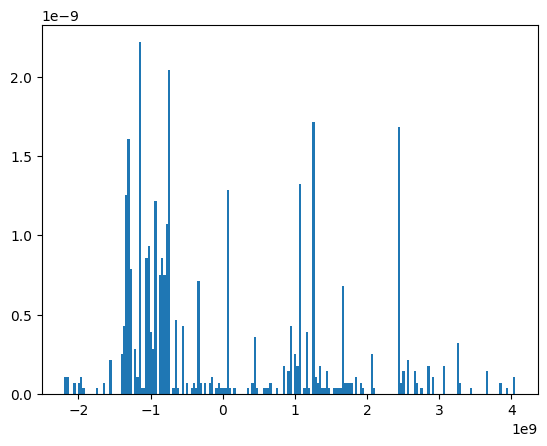

In [ ]:
probvfw, bins, pacthes= plt.hist(vfwpca, bins=200 ,density=True,  histtype='bar', label = 'VFW')
probvfw+=1e-10
probvfw

array([6.90978346e-10, 1.11808440e-08, 3.05489173e-09, 1.72519045e-09,
       1.00000000e-10, 5.43233760e-10, 2.90714714e-09, 1.00000000e-10,
       9.85114271e-09, 6.90978346e-10, 2.47744587e-10, 6.00978346e-09,
       1.00000000e-10, 1.00000000e-10, 1.72519045e-09, 2.47744587e-10,
       1.72519045e-09, 2.47744587e-10, 6.90978346e-10, 5.43233760e-10,
       1.00000000e-10, 2.47744587e-10, 1.00000000e-10, 1.00000000e-10,
       1.72519045e-09, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 2.47744587e-10, 2.47744587e-10, 8.66918602e-09,
       2.47744587e-10, 1.00000000e-10, 6.90978346e-10, 1.00000000e-10,
       2.47744587e-10, 2.47744587e-10, 6.00978346e-09, 2.47744587e-10,
       5.43233760e-10, 2.16842421e-09, 1.72519045e-09, 5.43233760e-10,
       1.13421211e-09, 2.16842421e-09, 1.57744587e-09, 2.16842421e-09,
       2.47744587e-10, 6.90978346e-10, 2.47744587e-10, 4.97557136e-09,
       2.47744587e-10, 1.00000000e-10, 2.47744587e-10, 1.00000000e-10,
      

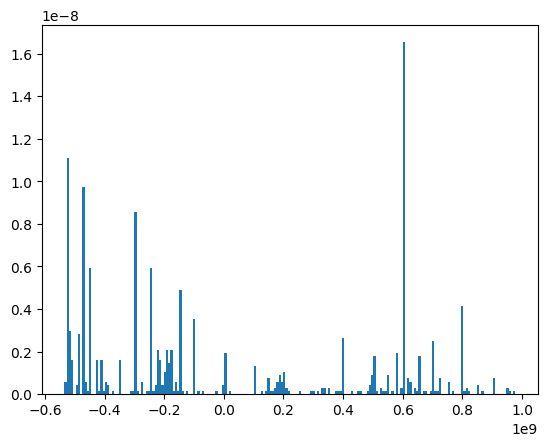

In [ ]:
probInline, bins, pacthes= plt.hist(Inlinepca, bins=200 ,density=True,  histtype='bar', label = 'Inline')
probInline+=1e-10
probInline

array([3.15331611e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       5.30663221e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       2.46864772e-09, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       5.30663221e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       3.15331611e-10, 1.00000000e-10, 3.15331611e-10, 1.00000000e-10,
       5.30663221e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       3.76063738e-09, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 3.15331611e-10, 3.15331611e-10, 1.00000000e-10,
       1.00000000e-10, 2.03798450e-09, 1.00000000e-10, 5.30663221e-10,
       1.00000000e-10, 1.82265289e-09, 1.00000000e-10, 7.45994832e-10,
       1.00000000e-10, 1.92645134e-08, 5.30663221e-10, 9.61326443e-10,
       1.00000000e-10, 9.61326443e-10, 3.15331611e-10, 9.61326443e-10,
       1.00000000e-10, 4.62196382e-09, 3.15331611e-10, 7.45994832e-10,
       9.61326443e-10, 5.30663221e-10, 7.45994832e-10, 1.00000000e-10,
      

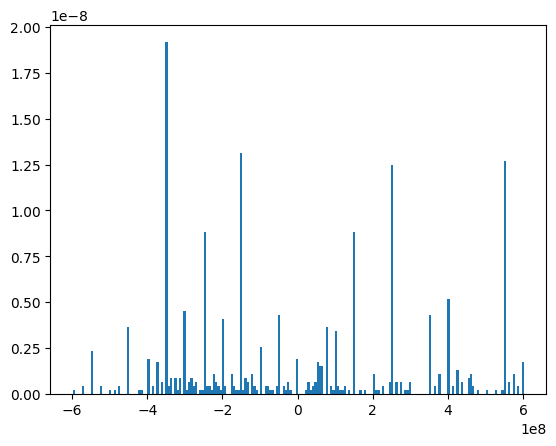

In [ ]:
_, Passivepca = table_evaluator2.plot_pca()
probPassive, bins, pacthes= plt.hist(Passivepca, bins=200 ,density=True,  histtype='bar', label = 'VFW')
probPassive+=1e-10
probPassive

In [ ]:
from scipy.stats import entropy #information loss use artpainting to describe photo
print('G sv')

format(((entropy(probInline, probvfw) + entropy(probPassive, probvfw))/3), '.10f')

G sv


'1.0826744062'

In [ ]:
from scipy.stats import entropy #information loss use artpainting to describe photo
print('G sv')

format(((entropy(probvfw, probInline) + entropy(probPassive, probInline))/3), '.10f')

G sv


'1.2461583834'

In [ ]:
from scipy.stats import entropy #information loss use artpainting to describe photo
print('G sv')

format(((entropy(probvfw, probPassive) + entropy(probInline, probPassive))/3), '.10f')

G sv


'1.3293497803'